# Pre-Entrega4: Modelos de Aprendizaje No Supervisados

### 🧭 OBJETIVO GENERAL

Este proyecto tiene como objetivo aplicar algoritmos de **aprendizaje no supervisado**, específicamente **clustering**, para descubrir patrones ocultos en nuestros datasets de producción de gas natural en Argentina.  

Trabajaremos con:

- **Dataset1**: Producción histórica agregada por cuenca y tipo de recurso.  
- **Dataset2**: Producción de pozos no convencionales.

Utilizaremos los siguientes algoritmos:

- **K-Means**  
- **DBSCAN**  
- **Gaussian Mixture Models (GMM)** (solo para Dataset2)

## Importación de Librerías  

Importamos las librerías necesarias para la carga de datos, preprocesamiento, modelado y visualización.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

import warnings

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Clustering con Dataset 1: Producción Histórica Agregada

El objetivo de esta sección es identificar grupos temporales con patrones de producción de gas natural similares, revelando así periodos con características distintivas o comportamientos anómalos en la serie histórica agregada.

###🔍 Carga e Inspección del Dataset1
Cargamos el dataset, revisamos columnas, tipos de datos y valores nulos. Filtramos los últimos 10 años para capturar las tendencias más recientes, y se renombraron algunas columnas.

In [ ]:
df1 = pd.read_csv('/content/serie-histrica-de-produccin-de-gas-natural-por-cuenca-y-sub-tipo-de-recurso-captulo-iv-.csv')

In [ ]:
df1.head()

,indice_tiempo,produccion_gas_natural_cuenca_austral,produccion_gas_natural_cuenca_gsj,produccion_gas_natural_cuenca_neuquina,produccion_gas_natural_cuenca_noroeste,produccion_gas_natural_cuenca_cuyana,produccion_gas_natural_total,produccion_gas_natural_total_diario,produccion_shale_gas,produccion_tight_gas,participacion_no_convencional
0,2006-01,856179.0548,357316.6790,2.401347e+06,609196.2466,5201.6404,4.229240e+06,136.4271,16.384,32491.62664,0.7686
1,2006-02,779265.9292,309565.3828,2.288115e+06,532122.4430,4273.6100,3.913342e+06,139.7622,13.954,30778.94772,0.7869
2,2006-03,807060.6516,384218.4085,2.507932e+06,588406.1140,5135.2570,4.292752e+06,138.4759,18.104,33024.46882,0.7697
3,2006-04,855962.9924,376149.2286,2.395269e+06,570671.5738,4986.4970,4.203039e+06,140.1013,19.627,31342.49019,0.7462
4,2006-05,905943.5735,409186.6946,2.571095e+06,562752.1099,5265.7730,4.454243e+06,143.6853,19.016,39199.71537,0.8805


In [ ]:
df1.shape

(231, 11)

In [ ]:
df1.dtypes

,0
indice_tiempo,object
produccion_gas_natural_cuenca_austral,float64
produccion_gas_natural_cuenca_gsj,float64
produccion_gas_natural_cuenca_neuquina,float64
produccion_gas_natural_cuenca_noroeste,float64
produccion_gas_natural_cuenca_cuyana,float64
produccion_gas_natural_total,float64
produccion_gas_natural_total_diario,float64
produccion_shale_gas,float64
produccion_tight_gas,float64


**Filtrar los últimos 10 años**

In [ ]:
# Convertir la columana 'indice_tiempo' en formato datetime
df1['indice_tiempo'] = pd.to_datetime(df1['indice_tiempo'])

# Cambiar de nombre a la columna 'indice_tiempo' por 'fecha'
df1.rename(columns={'indice_tiempo': 'fecha'}, inplace=True)

In [ ]:
# Agregar un columna solo con los meses que se llame 'mes' en formato numero entero
df1['mes'] = df1['fecha'].dt.month

In [ ]:
# Agregar un columna solo con los años que se llame 'anio'
df1['anio'] = df1['fecha'].dt.year

In [ ]:
# Asegurarse de que la columna de fecha esté en formato datetime

import pandas as pd
df1['fecha'] = pd.to_datetime(df1['fecha'])
df1.dtypes

,0
fecha,datetime64[ns]
produccion_gas_natural_cuenca_austral,float64
produccion_gas_natural_cuenca_gsj,float64
produccion_gas_natural_cuenca_neuquina,float64
produccion_gas_natural_cuenca_noroeste,float64
produccion_gas_natural_cuenca_cuyana,float64
produccion_gas_natural_total,float64
produccion_gas_natural_total_diario,float64
produccion_shale_gas,float64
produccion_tight_gas,float64


In [ ]:
# Ordenar por fecha para calcular los rezagos correctamente
df1 = df1.sort_values('fecha')

# Filtrar por rango de años (2006 a 2024)
df1 = df1[(df1['fecha'].dt.year >= 2006) &
                   (df1['fecha'].dt.year <= 2024)]

In [ ]:
# Filtrar últimos 10 años
df1 = df1[df1['fecha'] >= '2014-01-01']

In [ ]:
#Rango de Fechas
print(f"Rango de fechas del Dataset1 filtrado: {df1['fecha'].min().strftime('%Y-%m')} a {df1['fecha'].max().strftime('%Y-%m')}")

Rango de fechas del Dataset1 filtrado: 2014-01 a 2024-12


**Renombrar columnas**

In [ ]:
# Renombrar columnas
df1.rename(columns={
    'Gas Neuquina (miles de m3)': 'produccion_gas_natural_cuenca_neuquina',
    'Gas Austral (miles de m3)': 'produccion_gas_natural_cuenca_austral',
    'Gas Golfo San Jorge (miles de m3)': 'produccion_gas_natural_cuenca_gsj',
    'Gas Noroeste (miles de m3)': 'produccion_gas_natural_cuenca_noroeste',
    'Gas Cuyana (miles de m3)': 'produccion_gas_natural_cuenca_cuyana',
    'Gas shale (miles de m3)': 'produccion_shale_gas',
    'Gas tight (miles de m3)': 'produccion_tight_gas',
}, inplace=True)

### 🧮 Selección y Creación de Variables

Se incluyen variables como:

- Producción por cuenca y tipo de gas  
- Año, mes (como variables cíclicas), trimestres y estaciones


In [ ]:
# Transformación Cíclica del Mes
df1['mes_sin'] = np.sin(2 * np.pi * df1['mes'] / 12)
df1['mes_cos'] = np.cos(2 * np.pi * df1['mes'] / 12)

In [ ]:
# Variables Estacionales
def get_season(month):
    if month in [12, 1, 2]:
        return 'Verano'
    elif month in [3, 4, 5]:
        return 'Otoño'
    elif month in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df1['estacion'] = df1['mes'].apply(get_season)

In [ ]:
# Variables Trimestrales
df1['trimestre'] = df1['fecha'].dt.quarter

In [ ]:
# Variables Retardadas (Lagged Features)
df1['produccion_total_lag_1'] = df1['produccion_gas_natural_total'].shift(1)
df1['produccion_total_lag_2'] = df1['produccion_gas_natural_total'].shift(2)
df1['produccion_total_lag_3'] = df1['produccion_gas_natural_total'].shift(3)

# Manejar los valores nulos introducidos por los rezagos (NaNs en las primeras filas).
initial_rows_with_nan_lags = df1['produccion_total_lag_3'].isnull().sum()
df1.dropna(subset=['produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3'], inplace=True)
print(f"Se eliminaron {initial_rows_with_nan_lags} filas al inicio debido a los valores nulos en los rezagos.")

Se eliminaron 3 filas al inicio debido a los valores nulos en los rezagos.


In [ ]:
# Seleccionar características para clustering
features_1 = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'anio',
    'mes_sin',
    'mes_cos',
    'trimestre',
    'estacion',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3'
]

# Verificar si todas las columnas existen antes de continuar
missing_cols = [col for col in features_1 if col not in df1.columns]
if missing_cols:
    print(f"Advertencia: Las siguientes columnas no se encontraron en df1 y serán omitidas o se necesitará un paso previo para crearlas: {missing_cols}")
    # Remover las columnas faltantes de la lista de features para evitar errores
    features_1 = [col for col in features_1 if col in df1.columns]

X1 = df1[features_1].copy()

print(f"Características seleccionadas para Dataset1: {X1.columns.tolist()}")

Características seleccionadas para Dataset1: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'estacion', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']


### 🧼 Preprocesamiento de Datos  

Las etapas de preprocesamiento de los datos incluyen:

- Manejo de Valores Nulos
- Escalado de Variables Numéricas
- Codificación de Variables Categóricas
- Detección y Manejo de Outliers

#### 1. Manejo de Nulos  

Revisamos y tratamos posibles valores nulos que puedan afectar los modelos.


In [ ]:
df1.isna().sum()

,0
fecha,0
produccion_gas_natural_cuenca_austral,0
produccion_gas_natural_cuenca_gsj,0
produccion_gas_natural_cuenca_neuquina,0
produccion_gas_natural_cuenca_noroeste,0
produccion_gas_natural_cuenca_cuyana,0
produccion_gas_natural_total,0
produccion_gas_natural_total_diario,0
produccion_shale_gas,0
produccion_tight_gas,0


Se observa que en el Dataset 1 no posee valores nuelos, por lo que proseguimos con la codificación de variables.

#### 2. Escalado de Variables Numéricas (StandardScaler)  

Usamos **Z-score** para escalar variables de producción por cuenca, por tipo de gas y variables temporales como `trimestres` y `variables retardadas`, asegurando que ninguna variable domine por su magnitud.


In [ ]:
# Revisar qué tipo de dato es 'trimestre'
print(df1['trimestre'].dtype)

int32


In [ ]:
# Revisar qué tipo de dato son las variables retardadas
print(df1['produccion_total_lag_1'].dtype)
print(df1['produccion_total_lag_2'].dtype)
print(df1['produccion_total_lag_3'].dtype)

float64
float64
float64


#### 3. Codificación de Variables Categóricas (OneHotEncoder)  

Convertimos variables como `estación` a formato numérico utilizando OneHotEncoder.


In [ ]:
# Revisar qué tipo de dato es 'estacion'
print(df1['estacion'].dtype)

object


In [ ]:
# Identificar columnas numéricas y categóricas
numerical_features_1 = [col for col in X1.columns if X1[col].dtype in ['int32', 'int64', 'float64'] and col not in [ 'mes']]
categorical_features_1 = [col for col in X1.columns if X1[col].dtype in ['object']]

print("\nColumnas Numéricas identificadas:", numerical_features_1)
print("Columnas Categóricas identificadas:", categorical_features_1)


Columnas Numéricas identificadas: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']
Columnas Categóricas identificadas: ['estacion']


In [ ]:
# Preprocesamiento con Pipeline
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_1),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_1)
    ],
    remainder='passthrough'
)

# Aplicar el preprocesamiento
df1_processed_array = preprocessor_1.fit_transform(X1)

# Obtener los nombres de las características después del preprocesamiento
numerical_cols_processed = numerical_features_1
categorical_cols_processed = preprocessor_1.named_transformers_['cat'].get_feature_names_out(categorical_features_1)

# Combinar los nombres de las columnas procesadas
processed_feature_names_1 = list(numerical_cols_processed) + list(categorical_cols_processed)

# Convierte el array procesado de nuevo en un DataFrame
df1_processed = pd.DataFrame(df1_processed_array, columns=processed_feature_names_1, index=X1.index)


print(f"Dimensiones de los datos procesados para Dataset1: {df1_processed.shape}")
print(f"Columnas del DataFrame procesado: {df1_processed.columns.tolist()}")

Dimensiones de los datos procesados para Dataset1: (129, 18)
Columnas del DataFrame procesado: ['produccion_gas_natural_cuenca_neuquina', 'produccion_gas_natural_cuenca_austral', 'produccion_gas_natural_cuenca_gsj', 'produccion_gas_natural_cuenca_noroeste', 'produccion_gas_natural_cuenca_cuyana', 'produccion_shale_gas', 'produccion_tight_gas', 'anio', 'mes_sin', 'mes_cos', 'trimestre', 'produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano']


#### 4. Detección y Manejo de Outliers  

Identificamos y analizamos valores atípicos. Definimos un criterio para el manejo de estos outliers.


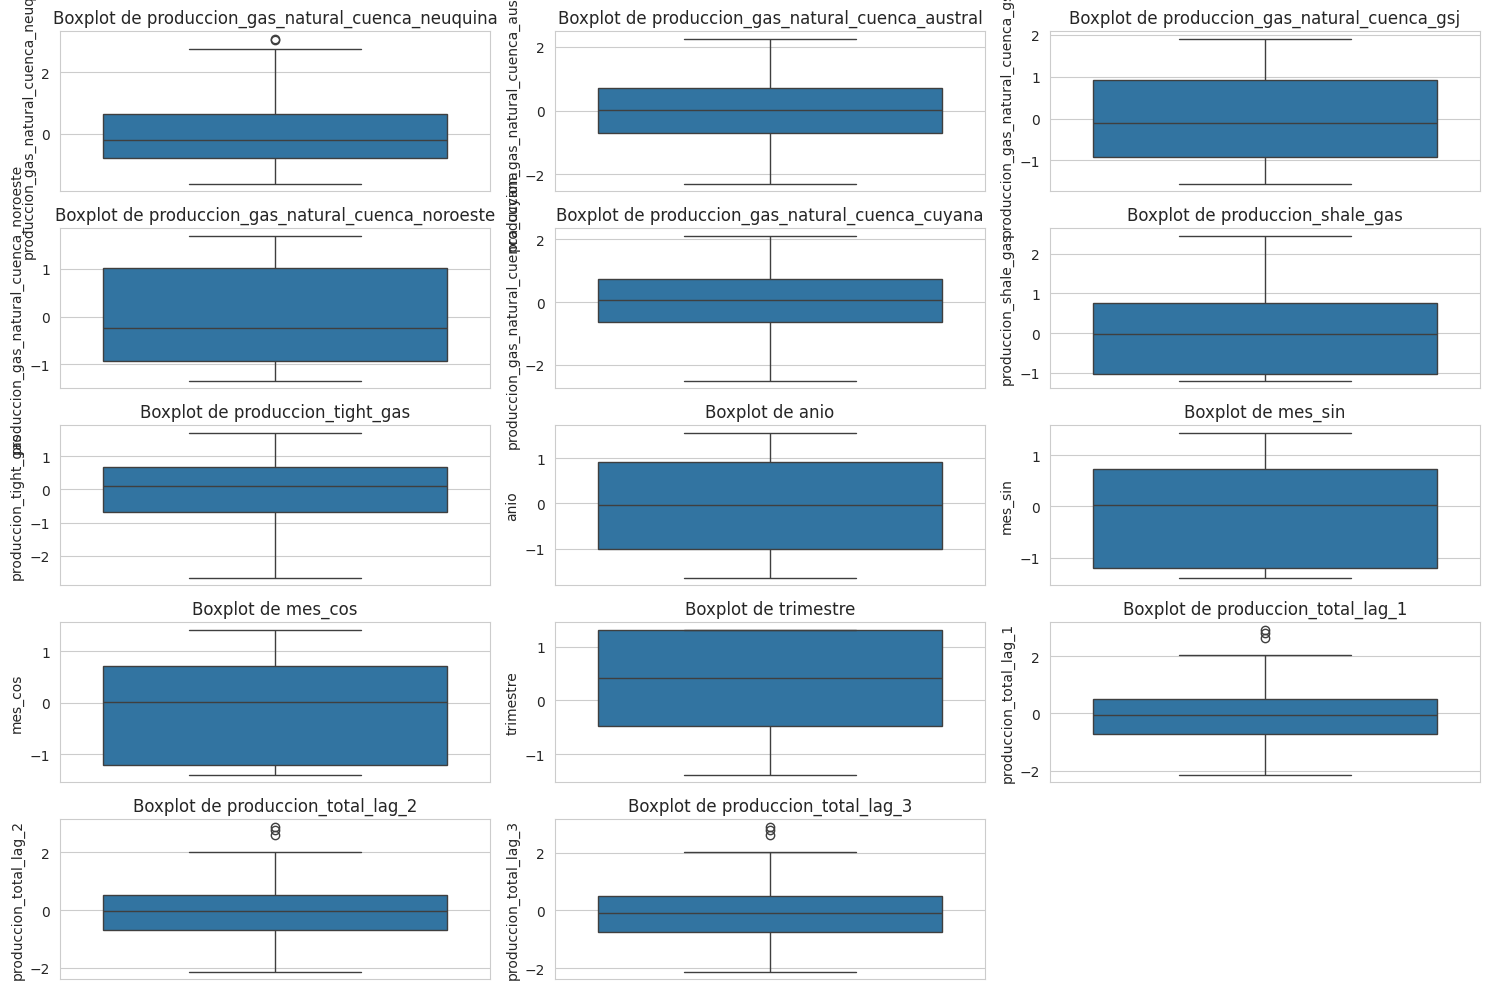

In [ ]:
# Seleccionar un subconjunto de columnas numéricas estandarizadas para visualizar outliers
cols_for_outlier_check = numerical_features_1

plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_for_outlier_check):
    if col in df1_processed.columns:
        plt.subplot(len(cols_for_outlier_check)//3 + 1, 3, i + 1)
        sns.boxplot(y=df1_processed[col])
        plt.title(f'Boxplot de {col}')
        plt.tight_layout()
    else:
        print(f"Advertencia: Columna '{col}' no encontrada en df1_processed.")

plt.show()

In [ ]:
# Identificar Outliers

# Función para identificar outliers usando IQR
def identify_outliers_iqr(df, column, lower_quantile=0.25, upper_quantile=0.75, multiplier=1.5):
    Q1 = df[column].quantile(lower_quantile)
    Q3 = df[column].quantile(upper_quantile)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Lista para almacenar el total de outliers encontrados
total_outliers_count = 0
outlier_details = {}

# Iterar sobre las columnas numéricas para identificar outliers
for col in numerical_features_1:
    # Usar el DataFrame procesado para la detección de outliers en datos escalados
    outliers_df = identify_outliers_iqr(df1_processed, col)
    num_outliers = len(outliers_df)
    total_outliers_count += num_outliers
    outlier_details[col] = num_outliers
    print(f"Columna '{col}': {num_outliers} outliers encontrados.")

# Calcular el total de puntos de datos
total_data_points = df1_processed.shape[0] * df1_processed.shape[1] # Total de elementos en el DataFrame procesado

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers = (total_outliers_count / total_data_points) * 100 if total_data_points > 0 else 0

print(f"Total de outliers identificados en columnas numéricas: {total_outliers_count}")
print(f"Total de datos en el DataFrame 1 procesado: {total_data_points}")
print(f"Porcentaje de outliers sobre el total de datos: {percentage_outliers:.2f}%")


Columna 'produccion_gas_natural_cuenca_neuquina': 2 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_austral': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_gsj': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_noroeste': 0 outliers encontrados.
Columna 'produccion_gas_natural_cuenca_cuyana': 0 outliers encontrados.
Columna 'produccion_shale_gas': 0 outliers encontrados.
Columna 'produccion_tight_gas': 0 outliers encontrados.
Columna 'anio': 0 outliers encontrados.
Columna 'mes_sin': 0 outliers encontrados.
Columna 'mes_cos': 0 outliers encontrados.
Columna 'trimestre': 0 outliers encontrados.
Columna 'produccion_total_lag_1': 3 outliers encontrados.
Columna 'produccion_total_lag_2': 3 outliers encontrados.
Columna 'produccion_total_lag_3': 3 outliers encontrados.
Total de outliers identificados en columnas numéricas: 11
Total de datos en el DataFrame 1 procesado: 2322
Porcentaje de outliers sobre el total de datos: 0.47%


**Outliers de 'produccion_gas_natural_cuenca_neuquina'**

In [ ]:
# Identificar outliers en 'produccion_gas_natural_cuenca_neuquina'

# Identificar los valores específicos que son outliers en 'produccion_gas_natural_cuenca_neuquina'
outliers_neuquina_df = identify_outliers_iqr(df1_processed, 'produccion_gas_natural_cuenca_neuquina')

# Mostrar los valores de la columna 'produccion_gas_natural_cuenca_neuquina' que son outliers
print("\nValores de 'produccion_gas_natural_cuenca_neuquina' identificados como outliers:")
print(outliers_neuquina_df['produccion_gas_natural_cuenca_neuquina'])


Valores de 'produccion_gas_natural_cuenca_neuquina' identificados como outliers:
222    3.049106
223    3.094341
Name: produccion_gas_natural_cuenca_neuquina, dtype: float64


Los outliers de `produccion_gas_natural_cuenca_neuquina` para las filas 222 (3.055814) y 223 (3.101659) indican que la producción actual de esos meses (Julio 2024 y Agosto 2024, respectivamente) fue atípica.

**Outliers de variables retardadas**

In [ ]:
#Identificar outliers en las variables retardadas:
#'produccion_total_lag_1', 'produccion_total_lag_2' y 'produccion_total_lag_3'

# Columnas de interés para los outliers
lag_cols = ['produccion_total_lag_1', 'produccion_total_lag_2', 'produccion_total_lag_3']

print("\n--- Outliers en variables retardadas ---")
for col in lag_cols:
    if col in df1_processed.columns:
        print(f"\nIdentificando outliers para la columna: '{col}'")
        # Identificar outliers usando la función identify_outliers_iqr en el DataFrame procesado
        outliers = identify_outliers_iqr(df1_processed, col)

        if not outliers.empty:
            print(f"Outliers encontrados en '{col}':")
            original_outlier_rows = df1.loc[outliers.index]
            print(original_outlier_rows[['fecha', col.replace('_processed', '')]])
        else:
            print(f"No se encontraron outliers en la columna: '{col}'")
    else:
        print(f"Advertencia: La columna '{col}' no se encontró en df1_processed.")


--- Outliers en variables retardadas ---

Identificando outliers para la columna: 'produccion_total_lag_1'
Outliers encontrados en 'produccion_total_lag_1':
         fecha  produccion_total_lag_1
221 2024-06-01            4.654371e+06
223 2024-08-01            4.709074e+06
224 2024-09-01            4.744011e+06

Identificando outliers para la columna: 'produccion_total_lag_2'
Outliers encontrados en 'produccion_total_lag_2':
         fecha  produccion_total_lag_2
222 2024-07-01            4.654371e+06
224 2024-09-01            4.709074e+06
225 2024-10-01            4.744011e+06

Identificando outliers para la columna: 'produccion_total_lag_3'
Outliers encontrados en 'produccion_total_lag_3':
         fecha  produccion_total_lag_3
223 2024-08-01            4.654371e+06
225 2024-10-01            4.709074e+06
226 2024-11-01            4.744011e+06


Los outliers de las variables retardadas indican un patrón:
- El valor 4.654371e+06 (que es un outlier) aparece en:

 - produccion_total_lag_1 para la fila 221

 - produccion_total_lag_2 para la fila 222

 - produccion_total_lag_3 para la fila 223

 Esto indica que la producción del mes que precede a la fila 221 (probablemente la producción de Mayo de 2024 o un mes similar si tus índices corresponden a una serie temporal) fue excepcionalmente alta y se manifestó como un outlier en los lags de las filas subsiguientes.

- De manera similar, el valor 4.709074e+06 (otro outlier) en lag_1 (fila 223), lag_2 (fila 224), lag_3 (fila 225) significa que la producción del mes que precede a la fila 223 (probablemente Julio de 2024) también fue un outlier.

- Y el valor 4.744011e+06 (otro outlier) en lag_1 (fila 224), lag_2 (fila 225), lag_3 (fila 226) significa que la producción del mes que precede a la fila 224 (probablemente Agosto de 2024) fue otro outlier.

**DECISIÓN:**
Los outliers en nuestro Dataset estan relacionados a vlores productivos atipicos. Y cómo nuestro objetivo es descubrir patrones y estructuras ocultas para identificaretapas productivas nos interesan los patrones que describen la mayoría de los pozos o los períodos de producción. Los outliers, por definición, representan desviaciones de esos patrones comunes. Por este motivo decidimos eliminarlos.

**Eliminar Outliers**

In [ ]:
# Elimina Outliers

# Almacenar el número inicial de filas
initial_rows = df1_processed.shape[0]
print(f"Filas iniciales antes de remover outliers: {initial_rows}")

# Crear una copia para no modificar el DataFrame original mientras se itera
df1_processed_cleaned = df1_processed.copy()

# Identificar y remover filas que contienen outliers en cualquiera de las columnas numéricas
no_outliers_mask = pd.Series(True, index=df1_processed.index)

for col in numerical_features_1:
    if col in df1_processed_cleaned.columns:
        Q1 = df1_processed_cleaned[col].quantile(0.25)
        Q3 = df1_processed_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        col_mask = (df1_processed_cleaned[col] >= lower_bound) & (df1_processed_cleaned[col] <= upper_bound)
        no_outliers_mask = no_outliers_mask & col_mask
    else:
        print(f"Advertencia: Columna '{col}' no encontrada en df1_processed_cleaned. No se considerará para la eliminación de outliers.")

# Aplicar la máscara para filtrar las filas sin outliers
df1_processed_cleaned = df1_processed_cleaned[no_outliers_mask]

# Almacenar el número de filas después de remover outliers
rows_after_removing_outliers = df1_processed_cleaned.shape[0]
print(f"Filas después de remover outliers: {rows_after_removing_outliers}")

# Calcular el total de filas eliminadas
removed_rows_count = initial_rows - rows_after_removing_outliers
print(f"Total de filas eliminadas: {removed_rows_count}")

# Imprimir las dimensiones del DataFrame después de remover outliers
print(f"Dimensiones del DataFrame después de remover outliers: {df1_processed_cleaned.shape}")

# Guardar los cambios en df1_processed
df1_processed = df1_processed_cleaned

# Guardar los cambios en df1
df1 = df1_processed

Filas iniciales antes de remover outliers: 129
Filas después de remover outliers: 123
Total de filas eliminadas: 6
Dimensiones del DataFrame después de remover outliers: (123, 18)


### 🤖 Aplicación de Algoritmos de Clustering

Implementaremos K-Means y DBSCAN para el Dataset 1.


#### 📊 K-Means  

Aplicamos K-Means y determinamos el número óptimo de clusters con:

- **Método del Codo**  
- **Coeficiente de Silueta**

Ambos métodos permiten evaluar la cohesión y separación de los grupos.


In [ ]:
# Definir lista de columnas a usar para K-Means
features_for_clustering = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'anio',
    'mes_sin',
    'mes_cos',
    'trimestre',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3',
    'estacion_Invierno',
    'estacion_Otoño',
    'estacion_Primavera',
    'estacion_Verano'
]

# Crear un sub-DataFrame con las características deseadas para el clustering
df_for_models = df1_processed[features_for_clustering].copy()

K = 2, Coeficiente de Silueta = 0.262
K = 3, Coeficiente de Silueta = 0.218
K = 4, Coeficiente de Silueta = 0.211
K = 5, Coeficiente de Silueta = 0.213
K = 6, Coeficiente de Silueta = 0.204
K = 7, Coeficiente de Silueta = 0.205
K = 8, Coeficiente de Silueta = 0.202
K = 9, Coeficiente de Silueta = 0.204
K = 10, Coeficiente de Silueta = 0.202


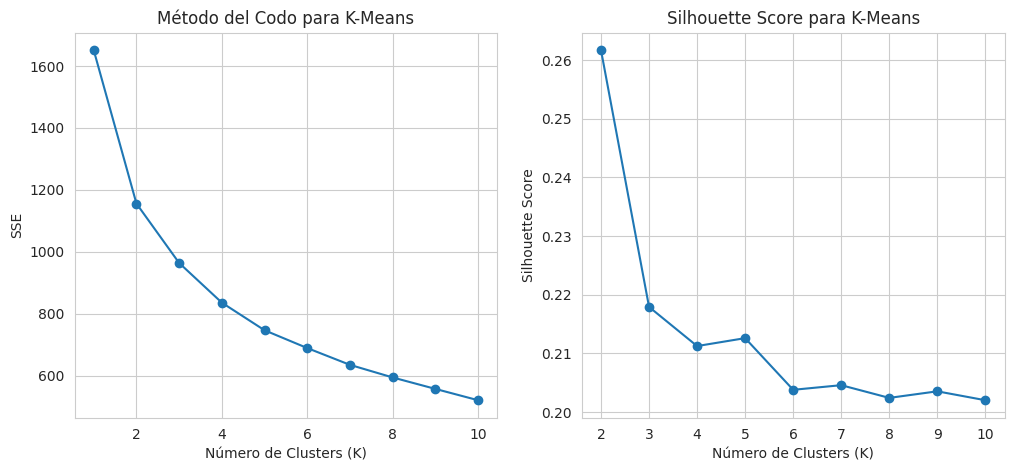

In [ ]:
# Determinar el número óptimo de clusters (k) para K-Means

# Método del Codo
sse = []
k_range = range(1, 11)

# Usar df_for_models para clustering
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_for_models)
    sse.append(kmeans.inertia_)

# Visualizar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('SSE')

# Coeficiente de Silueta
silhouette_scores = []

# Usar df_for_models para clustering
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_for_models)
    score = silhouette_score(df_for_models, cluster_labels)
    silhouette_scores.append(score)
    print(f"K = {k}, Coeficiente de Silueta = {score:.3f}")

# Visualizar Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

1. **Método del Codo (Elbow Method)**

La curva de inercia comienza a estabilizarse en K=3 o K=4, lo que sugiere que uno de estos valores podría ser adecuado. Sin embargo, la reducción de la inercia después de este punto es menos pronunciada, haciendo que la elección no sea completamente clara.

2. **Coeficiente de Silueta (Silhouette Score)**

El valor más alto del coeficiente se obtiene en K=2 (0.282), lo que indica que en esta configuración los grupos están más claramente separados y los puntos dentro de cada grupo son más similares entre sí. A partir de K=3, la puntuación disminuye significativamente, alcanzando su punto más bajo en K=6 (0.282).

**Conclusión Preliminar:**

Aunque el Método del Codo sugiere K=3 o K=4, su interpretación es ambigua. En cambio, el Coeficiente de Silueta ofrece un respaldo claro y objetivo a K=2 como la mejor opción. Esto indica que los datos se estructuran de forma más natural y eficiente en dos clusters bien diferenciados.

In [ ]:
# Seleccionar k óptimo
k_optimo_kmeans1 = 2

kmeans1 = KMeans(n_clusters=k_optimo_kmeans1, random_state=42, n_init=10)
# Ajustar los datos procesados
kmeans1.fit(df_for_models)
# Predecir clusters para los datos procesados
cluster_labels_kmeans1 = kmeans1.predict(df_for_models)
# Asignar las etiquetas de cluster a df_for_models
df1.loc[df_for_models.index, 'kmeans_cluster'] = cluster_labels_kmeans1


print(f"\nSe ha ejecutado K-Means con k = {k_optimo_kmeans1} para Dataset1.")
print(f"Conteo de elementos por cluster K-Means:\n{df1['kmeans_cluster'].value_counts()}")


Se ha ejecutado K-Means con k = 2 para Dataset1.
Conteo de elementos por cluster K-Means:
kmeans_cluster
1.0    73
0.0    50
Name: count, dtype: int64


#### 🌐 DBSCAN  

Exploramos este algoritmo basado en densidad. Las claves:

- **eps**: Radio de vecindad  
- **min_samples**: Mínimo de puntos por vecindad  

Utilizamos el **gráfico de la distancia al K-vecino más cercano** para elegir un buen valor de `eps`.


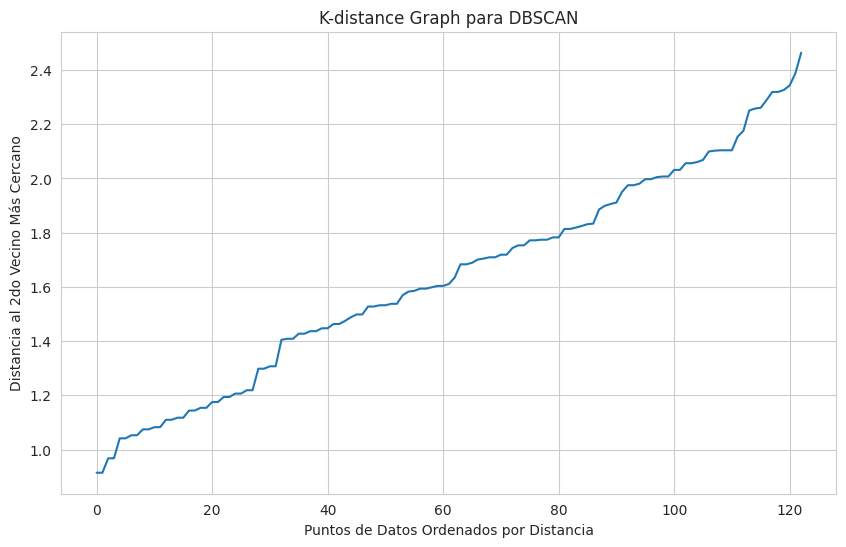

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_for_models)
distances, indices = nbrs.kneighbors(df_for_models)
distances = np.sort(distances[:, 1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph para DBSCAN')
plt.xlabel('Puntos de Datos Ordenados por Distancia')
plt.ylabel('Distancia al 2do Vecino Más Cercano')
plt.show()

Basado en el Gráfico de Distancia K:

- `eps` (épsilon): Aproximadamente entre 1.6 y 1.7. Por lo que elegimos un valor como 1.65 para empezar.

- `min_samples` (puntos mínimos): 3 dado que el gráfico es para el 2do vecino más cercano.

In [ ]:
# # Aplicación y evaluación de DBSCAN
## con eps = 1.65 y min_samples = 3
dbscan = DBSCAN(eps=1.65, min_samples=3)
clusters_dbscan = dbscan.fit_predict(df_for_models)

# # Unir los clusters al DataFrame original o procesado
df1.loc[df_for_models.index, 'dbscan_cluster'] = clusters_dbscan

# # Evaluar la puntuación de silueta (ignorar -1, que es ruido)
unique_labels = np.unique(clusters_dbscan)
n_clusters_excluding_noise = len(unique_labels[unique_labels != -1])

if n_clusters_excluding_noise > 1:
    # Calcular la puntuación de la silueta excluyendo los puntos de ruido (-1)
    score_dbscan = silhouette_score(df_for_models[clusters_dbscan != -1], clusters_dbscan[clusters_dbscan != -1])
    print(f"Silhouette Score para DBSCAN (excluyendo ruido): {score_dbscan}")
elif len(unique_labels) > 1:
    # Si hay clusters pero sólo un cluster sin ruido, todavía no se puede calcular la silueta sin ruido
     print("DBSCAN encontró clusters, pero sólo un cluster sin ruido para calcular la puntuación de silueta.")
else:
    print("DBSCAN no formó suficientes clusters (o sólo encontró ruido) para calcular la puntuación de silueta.")

print(f"\nSe ha ejecutado DBSCAN con eps = {dbscan.eps} y min_samples = {dbscan.min_samples} para Dataset1.")
print(f"Conteo de elementos por cluster DBSCAN (Dataset1):\n{df1['dbscan_cluster'].value_counts()}")
print("Nota: El cluster -1 representa outliers (ruido).")

Silhouette Score para DBSCAN (excluyendo ruido): 0.38254804739986914

Se ha ejecutado DBSCAN con eps = 1.65 y min_samples = 3 para Dataset1.
Conteo de elementos por cluster DBSCAN (Dataset1):
dbscan_cluster
-1.0    86
 3.0     6
 7.0     5
 0.0     4
 4.0     4
 1.0     4
 6.0     4
 5.0     4
 2.0     3
 8.0     3
Name: count, dtype: int64
Nota: El cluster -1 representa outliers (ruido).


Dado que hay algunos puntos que se clasificaron como ruido, el primer paso sería aumentar el valor de eps de forma incremental. Vuelvemos a ejecutar DBSCAN con pero con los siguientes valores `eps = 1.8` y` min_samples = 3`

In [ ]:
# --- Para DBSCAN ---
## con eps = 1.80 y min_samples = 3

# # Aplicación y evaluación de DBSCAN
dbscan_v2 = DBSCAN(eps=1.80, min_samples=3)
clusters_dbscan_v2 = dbscan_v2.fit_predict(df_for_models)

# Asignar a la columna 'dbscan_cluster'
df1.loc[df_for_models.index, 'dbscan_cluster'] = clusters_dbscan_v2

# Evaluar la puntuación de silueta
unique_labels_v2 = np.unique(clusters_dbscan_v2)
n_clusters_excluding_noise_v2 = len(unique_labels_v2[unique_labels_v2 != -1])

if n_clusters_excluding_noise_v2 > 1:
    score_dbscan_v2 = silhouette_score(df_for_models[clusters_dbscan_v2 != -1], clusters_dbscan_v2[clusters_dbscan_v2 != -1])
    print(f"Silhouette Score para DBSCAN (excluyendo ruido) con eps={dbscan_v2.eps}: {score_dbscan_v2}")
elif len(unique_labels_v2) > 1:
    print("DBSCAN encontró clusters, pero sólo un cluster sin ruido para calcular la puntuación de silueta.")
else:
    print("DBSCAN no formó suficientes clusters (o sólo encontró ruido) para calcular la puntuación de silueta.")

print(f"\nSe ha ejecutado DBSCAN con eps = {dbscan_v2.eps} y min_samples = {dbscan_v2.min_samples} para Dataset1.")
print(f"Conteo de elementos por cluster DBSCAN (Dataset1):\n{df1['dbscan_cluster'].value_counts()}")
print("Nota: El cluster -1 representa outliers (ruido).")

Silhouette Score para DBSCAN (excluyendo ruido) con eps=1.8: 0.36522969237272096

Se ha ejecutado DBSCAN con eps = 1.8 y min_samples = 3 para Dataset1.
Conteo de elementos por cluster DBSCAN (Dataset1):
dbscan_cluster
-1.0    74
 0.0    12
 2.0     6
 7.0     5
 5.0     4
 4.0     4
 3.0     4
 9.0     4
 6.0     4
 1.0     3
 8.0     3
Name: count, dtype: int64
Nota: El cluster -1 representa outliers (ruido).


Manteniendo `min_samples = 3`, al aumentar `eps a 1.8`, el Silhouette Score se mantiene en un nivel muy alto, mientras que el número de puntos de ruido disminuye (74). Esto significa que estamos capturando la misma buena calidad de clústeres que antes, y posiblemente con clústeres un poco más grandes.

### 📉 Análisis Exploratorio y Visualización de Clusters  

Reducimos la dimensionalidad con **PCA** para visualizar los resultados y analizamos promedios por cluster.


In [ ]:
# Reducción de Dimensionalidad con PCA
pca_1 = PCA(n_components=2)
# Aplicar PCA en df_for_models
X1_pca = pca_1.fit_transform(df_for_models)

# Asignar los componentes PCA a df1 usando el índice de df_for_models
df1.loc[df_for_models.index, 'pca1'] = X1_pca[:, 0]
df1.loc[df_for_models.index, 'pca2'] = X1_pca[:, 1]

#### 📌 K-Means  

- Análisis de Clusters K-Means (Dataset1)


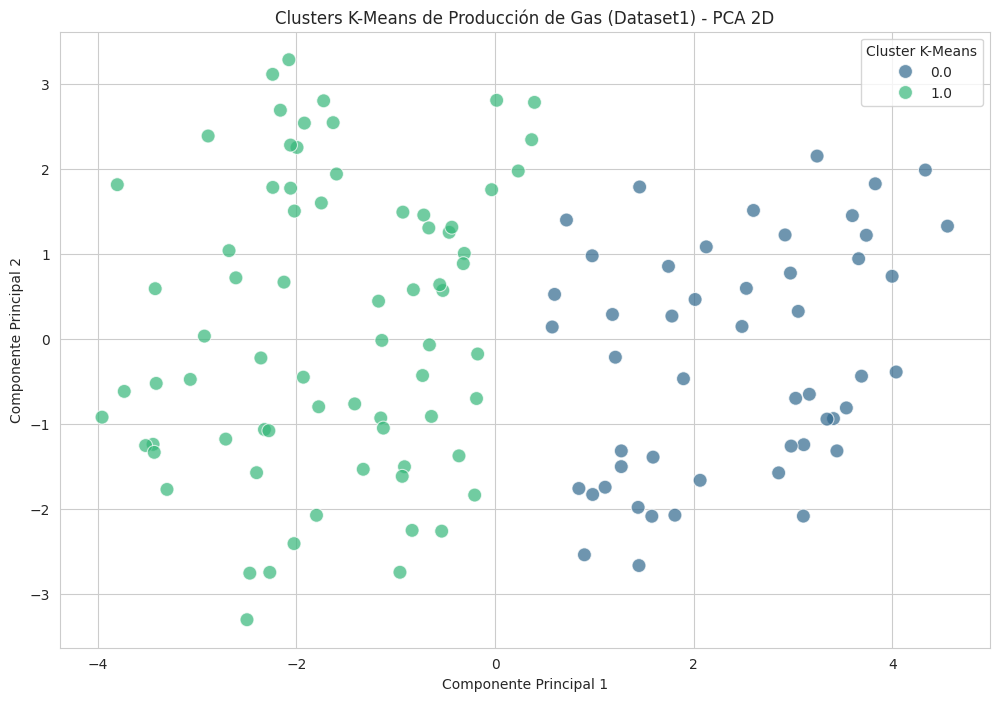


Características promedio por Cluster (K-Means - Dataset1):
                produccion_gas_natural_cuenca_neuquina  \
kmeans_cluster                                           
0.0                                          -0.853054   
1.0                                           0.410840   

                produccion_gas_natural_cuenca_austral  \
kmeans_cluster                                          
0.0                                         -0.097850   
1.0                                          0.174539   

                produccion_gas_natural_cuenca_gsj  \
kmeans_cluster                                      
0.0                                      1.105846   
1.0                                     -0.657159   

                produccion_gas_natural_cuenca_noroeste  \
kmeans_cluster                                           
0.0                                           1.120012   
1.0                                          -0.663200   

                produccion_gas_n

In [ ]:
## K-MEANS
#2 Clusters

# Visualización de Clusters (K-Means)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters K-Means de Producción de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.show()

# Características promedio por Cluster (K-Means)
non_temporal_features = [col for col in features_for_clustering if col not in ['anio', 'mes_sin', 'mes_cos', 'trimestre', 'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera', 'estacion_Verano']]

# Calcular el promedio de las características NO TEMPORALES para cada clúster
cluster_summary_kmeans1 = df1.loc[df_for_models.index].groupby('kmeans_cluster')[
    non_temporal_features
].mean()
print("\nCaracterísticas promedio por Cluster (K-Means - Dataset1):")
print(cluster_summary_kmeans1)

# Análisis de Variables Temporales por Cluster (K-Means)
print("\nAnálisis Temporal por Cluster (K-Means - Dataset1):")

# Preparar un DataFrame para el análisis temporal con los valores originales
df1_for_temporal_analysis = df1.loc[df_for_models.index].copy()


for cluster_id in sorted(df1_for_temporal_analysis['kmeans_cluster'].unique()):
    # Filtrar el DataFrame de análisis temporal por el cluster_id actual
    cluster_data_temporal = df1_for_temporal_analysis[df1_for_temporal_analysis['kmeans_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} ---")

    # Revisar que las columnas existan en el DataFrame y que sean las originales
    if 'anio' in cluster_data_temporal.columns:
        print(f"Años representados: {cluster_data_temporal['anio'].min()} - {cluster_data_temporal['anio'].max()}")
    else:
        print("Advertencia: La columna 'anio' original no encontrada para análisis temporal.")

    # mes
    if 'mes' in cluster_data_temporal.columns:
        print(f"Meses (distribución): \n{cluster_data_temporal['mes'].value_counts(normalize=True).sort_index().round(2)}")
    else:
        print("Advertencia: La columna 'mes' original no encontrada para análisis temporal.")

    # estacion
    if 'estacion' in cluster_data_temporal.columns:
        print(f"Estaciones (distribución): \n{cluster_data_temporal['estacion'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'estacion' original no encontrada para análisis temporal.")

    # trimetre
    if 'trimestre' in cluster_data_temporal.columns:
        print(f"Trimestres (distribución): \n{cluster_data_temporal['trimestre'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'trimestre' original no encontrada para análisis temporal.")


#### **Análisis de Clusters K-Means (Dataset1)**

El modelo K-Means identificó dos clústeres bien diferenciados en la producción de gas no convencional en Argentina durante la última década, revelando una transición clara entre dos etapas productivas.

---

###### **Cluster 0 (Color Azul/Gris en el gráfico):**

Representa los años 2014-2018, una etapa temprana del desarrollo del gas no convencional, con niveles de producción más moderados.

*  **Producción por Cuenca:**
Alta producción en Golfo San Jorge (1.10) y Noroeste (1.12). En cambio, la Cuenca Neuquina (-0.85), principal impulsora del shale gas, muestra valores muy por debajo del promedio.

* **Tipo de recurso:**
Shale gas (-1.03) y tight gas (-0.17) presentan bajos niveles de producción.

* **Producción total (lag):**
Indicadores de producción total histórica en niveles consistentemente bajos.

* **Patrón temporal:**
Distribución mensual uniforme sin estacionalidad clara.

**Interpretación del Cluster 0:**

Este clúster agrupa períodos caracterizados por una baja producción general de gas natural, en particular desde la Cuenca Neuquina y en los recursos no convencionales como el shale gas. En contraste, las cuencas tradicionales como Golfo San Jorge y Noroeste presentan una producción significativamente superior al promedio, y la Cuenca Cuyana también muestra un leve protagonismo.
Además, los indicadores de producción total con rezago (lag) reflejan niveles consistentemente bajos, lo que refuerza la idea de una etapa previa al auge del desarrollo no convencional.
En conjunto, este clúster representa un modelo de producción más conservador y basado en cuencas históricas, previo al cambio estructural impulsado por el shale gas en años posteriores.

---

###### **Cluster 1 (Color Verde en el Gráfico)**

Corresponde a la etapa de mayor desarrollo y alta producción en Argentina, impulsada principalmente por recursos no convencionales.

* **Producción por Cuenca:** Destaca la Cuenca Neuquina con niveles por encima del promedio (0.41), mientras que las cuencas tradicionales como Golfo San Jorge (-0.65) y Noroeste (-0.66) están por debajo del promedio.

* **Producción por Tipo de Recurso:** El shale gas (0.54) y tight gas (0.20) presentan una contribución significativa y superior al promedio.

* **Producción Total Retardada:** Los valores con rezagos (lag 1, 2 y 3) muestran una producción sostenida y por encima del promedio.

* **Análisis Temporal:** Abarca los años 2018-2024, reflejando los años más recientes y de mayor crecimiento del sector, con una distribución uniforme sin estacionalidad marcada. El volumen sostenido de producción es el principal factor diferenciador.

**Interpretación del Cluster 1:**

Este patrón refleja un patrón de producción reciente dominado por la Cuenca Neuquina y los recursos no convencionales, con un desempeño superior al promedio. En contraste, las cuencas tradicionales presentan una menor producción. En conjunto, representa la etapa actual de expansión y consolidación del gas no convencional en Argentina.

#### 📌 DBSCAN  

- Análisis de Clusters DBSCAN (Dataset1)  
- DBSCAN – Análisis del Ruido


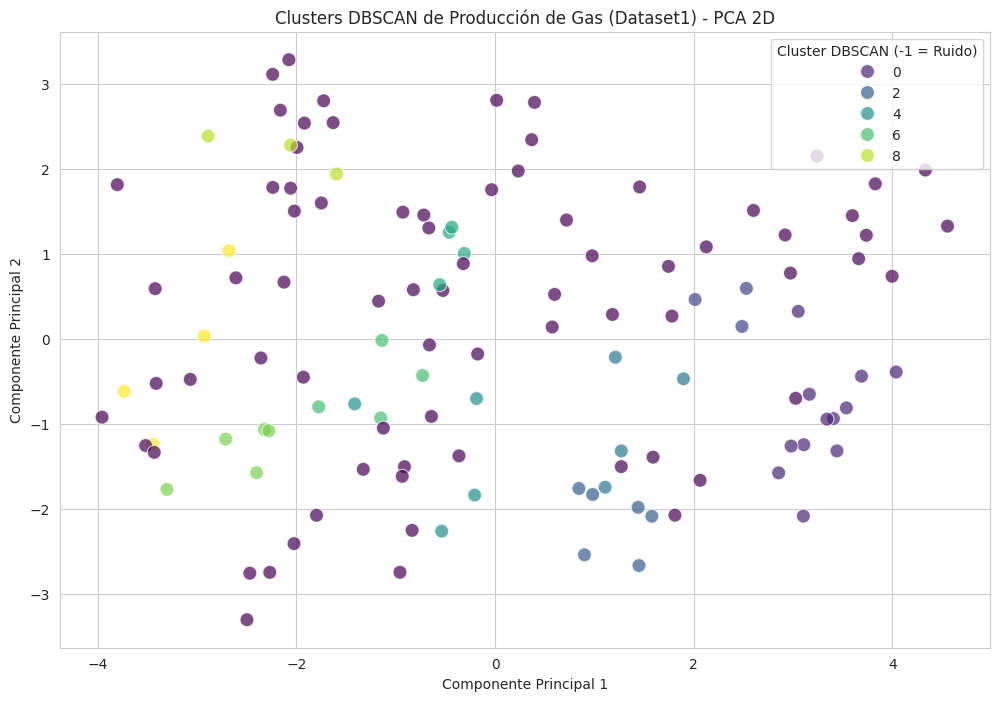


Características promedio por Cluster (DBSCAN - Dataset1):
                produccion_gas_natural_cuenca_neuquina  \
dbscan_cluster                                           
0.0                                          -1.086219   
1.0                                          -0.662440   
2.0                                          -0.713330   
3.0                                          -0.630909   
4.0                                           0.201823   
5.0                                          -0.210042   
6.0                                           0.386535   
7.0                                           0.527365   
8.0                                           0.781153   
9.0                                           1.673073   

                produccion_gas_natural_cuenca_austral  \
dbscan_cluster                                          
0.0                                         -0.489782   
1.0                                          0.242192   
2.0             

In [ ]:
## DBSCAN

# Visualización de Clusters (DBSCAN)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='dbscan_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters DBSCAN de Producción de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.show()

# Características promedio por Cluster (DBSCAN)
print("\nCaracterísticas promedio por Cluster (DBSCAN - Dataset1):")

# Definir las características no temporales para el cálculo de promedios.
non_temporal_features = [
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'produccion_total_lag_1',
    'produccion_total_lag_2',
    'produccion_total_lag_3'
]

# Crear un DataFrame para el análisis basado en df1 y df_for_models.index
df1_for_dbscan_analysis = df1.loc[df_for_models.index].copy()

# Filtrar el ruido (-1.0) antes de calcular los promedios.
clusters_no_noise_dbscan = df1_for_dbscan_analysis[df1_for_dbscan_analysis['dbscan_cluster'] != -1.0]

# Calcula el promedio de las características NO TEMPORALES para cada clúster.
cluster_summary_dbscan = clusters_no_noise_dbscan.groupby('dbscan_cluster')[
    non_temporal_features
].mean()
print(cluster_summary_dbscan)

# Análisis de Variables Temporales por Cluster (DBSCAN)
print("\nAnálisis Temporal por Cluster (DBSCAN - Dataset1):")

# Filtrar el ruido para el análisis temporal también.
clusters_no_noise_temporal_dbscan = df1_for_dbscan_analysis[df1_for_dbscan_analysis['dbscan_cluster'] != -1.0]

# Iterar sobre cada ID de clúster encontrado (excluyendo el ruido)
for cluster_id in sorted(clusters_no_noise_temporal_dbscan['dbscan_cluster'].unique()):
    # Filtra el DataFrame por el cluster_id actual
    cluster_data_temporal_dbscan = clusters_no_noise_temporal_dbscan[clusters_no_noise_temporal_dbscan['dbscan_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} (DBSCAN) ---")

    # Comprobar y mostrar las estadísticas de las columnas temporales originales
for cluster_id in sorted(clusters_no_noise_temporal_dbscan['dbscan_cluster'].unique()):
    cluster_data_temporal_dbscan = clusters_no_noise_temporal_dbscan[clusters_no_noise_temporal_dbscan['dbscan_cluster'] == cluster_id]

    print(f"\n--- Cluster {cluster_id} (DBSCAN) ---")
    if 'anio' in cluster_data_temporal_dbscan.columns:
        print(f"Años representados: {cluster_data_temporal_dbscan['anio'].min()} - {cluster_data_temporal_dbscan['anio'].max()}")
    else:
        print("Advertencia: La columna 'anio' original no encontrada en el DataFrame para análisis temporal.")

    if 'mes' in cluster_data_temporal_dbscan.columns:
        print(f"Meses (distribución): \n{cluster_data_temporal_dbscan['mes'].value_counts(normalize=True).sort_index().round(2)}")
    else:
        print("Advertencia: La columna 'mes' original no encontrada en el DataFrame para análisis temporal. (Si usaste mes_sin/mes_cos, los promedios ya están en cluster_summary_dbscan).")

    if 'estacion' in cluster_data_temporal_dbscan.columns:
        print(f"Estaciones (distribución): \n{cluster_data_temporal_dbscan['estacion'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'estacion' original no encontrada en el DataFrame para análisis temporal. (Si usaste OHEs, puedes promediar las columnas 'estacion_X' en su lugar).")

    if 'trimestre' in cluster_data_temporal_dbscan.columns:
        print(f"Trimestres (distribución): \n{cluster_data_temporal_dbscan['trimestre'].value_counts(normalize=True).round(2)}")
    else:
        print("Advertencia: La columna 'trimestre' original no encontrada en el DataFrame para análisis temporal. (Si está estandarizada, ya se promedió en cluster_summary_dbscan).")


#### Análisis de Clusters DBSCAN (Dataset1)

El modelo DBSCAN identificó 10 clústeres que segmentan la evolución de la producción de gas no convencional en Argentina en tres grandes etapas: tradicional, transición y auge.

**1. Era Tradicional (Clústeres 0.0 y 1.0)**

* Predominan cuencas convencionales (GSJ, Noroeste, Cuyana).
* Producción muy baja en Neuquina y nula en recursos no convencionales (shale y tight gas).
* Producción total baja.
* Se concentran en los años más tempranos del dataset.

**Insight clave:** Reflejan un modelo productivo centrado en cuencas maduras, sin presencia no convencional.

**2. Etapa de Transición (Clústeres 2.0 a 5.0)**
* Neuquina y Austral comienzan a crecer.
* Tight gas gana protagonismo, mientras las cuencas tradicionales pierden peso.
* Shale gas aparece tímidamente.
* Producción total empieza a repuntar.

**Temporalidad:** Años intermedios, con distribución de trimestres más diversa.

**Insight clave:** Esta fase marca el cambio hacia un modelo más moderno, con señales claras del cambio de matriz productiva.

**3. Auge de No Convencionales (Clústeres 6.0 a 9.0)**

* Neuquina se vuelve dominante, especialmente en el clúster 9.0.
* Shale gas alcanza sus valores máximos, impulsando el crecimiento total.
* Tight gas tiene un rol variable pero importante.
* Cuencas tradicionales quedan relegadas.

**Temporalidad:** Años recientes; algunos clústeres están concentrados en trimestres específicos, reflejando momentos productivos puntuales.

**Insight clave:** Esta etapa representa el pleno auge del modelo no convencional, liderado por el shale gas neuquino.

**Conclusiones**

* DBSCAN permite segmentar la evolución histórica del gas argentino con mayor sensibilidad a transiciones sutiles.
* Aporta un enfoque complementario a modelos como K-Means, captando tanto microestructuras como el cambio progresivo en el patrón productivo.

####📌 DBSCAN

* Análisis de Clusters DBSCAN (Dataset1)
* DBSCAN – Análisis del Ruido


In [ ]:
# Analisis de Ruido en DBSCAN

# Filtrar los puntos que DBSCAN identificó como ruido (-1)
df_for_dbscan_analysis_noise = df1.loc[df_for_models.index].copy()
ruido_dbscan = df_for_dbscan_analysis_noise[df_for_dbscan_analysis_noise['dbscan_cluster'] == -1.0]

print(f"Se identificaron {len(ruido_dbscan)} puntos como ruido por DBSCAN.")

if not ruido_dbscan.empty:
    ruido_data_for_analysis = ruido_dbscan.copy()

    print("Filas correspondientes a los puntos de ruido (-1):")
    cols_to_show_ruido = non_temporal_features.copy()
    if 'dbscan_cluster' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('dbscan_cluster')
    if 'kmeans_cluster' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('kmeans_cluster')
    if 'pca1' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('pca1')
    if 'pca2' in ruido_data_for_analysis.columns:
        cols_to_show_ruido.append('pca2')

    cols_to_show_ruido_existing = [col for col in cols_to_show_ruido if col in ruido_data_for_analysis.columns]

    print(ruido_data_for_analysis[cols_to_show_ruido_existing].round(6))

    print("\nCaracterísticas promedio de los puntos de ruido:")
    production_features_existing_in_noise = [col for col in non_temporal_features if col in ruido_data_for_analysis.columns]
    if production_features_existing_in_noise:
        print(ruido_data_for_analysis[production_features_existing_in_noise].mean().round(6))
    else:
        print("No hay características de producción para promediar en los puntos de ruido (o las columnas no coinciden).")

    print("\nAnálisis Temporal de los puntos de ruido:")
    temporal_cols = ['anio', 'mes', 'trimestre', 'estacion']
    temporal_cols_existing = [col for col in temporal_cols if col in ruido_data_for_analysis.columns]

    for col in temporal_cols_existing:
        print(f"Distribución de '{col}' en puntos de ruido:")
        if col in ['anio', 'mes', 'trimestre']:
            print(ruido_data_for_analysis[col].value_counts(normalize=True).sort_index().round(6))
        else:
            print(ruido_data_for_analysis[col].value_counts(normalize=True).round(6))

else:
    print("No se identificaron puntos como ruido por DBSCAN con los parámetros actuales.")

Se identificaron 74 puntos como ruido por DBSCAN.
Filas correspondientes a los puntos de ruido (-1):
     produccion_gas_natural_cuenca_neuquina  \
99                                -1.620845   
100                               -1.257701   
101                               -1.407556   
108                               -1.077623   
109                               -1.585335   
..                                      ...   
216                                0.750528   
217                                0.871963   
218                                1.471779   
220                                2.763456   
227                                0.752393   

     produccion_gas_natural_cuenca_austral  produccion_gas_natural_cuenca_gsj  \
99                               -1.365153                           0.782760   
100                               0.091966                           0.905411   
101                              -0.240600                           0.683668   
108       

**Conclusión del Análisis de Ruido:**

Conclusión sobre el Análisis de Ruido
Los 86 puntos clasificados como ruido por DBSCAN representan observaciones atípicas que no encajan en los clústeres densos identificados. Aunque sus valores promedios son cercanos al promedio general, tanto el análisis individual como la visualización en PCA muestran que son casos aislados o dispersos.

Estos outliers están distribuidos a lo largo de todo el período analizado, con una leve concentración en algunos trimestres, lo que indica que las anomalías en la producción pueden ocurrir en cualquier momento, reflejando condiciones excepcionales que los métodos basados en densidad no logran agrupar.

#### 📊 Comparación  

- Comparación entre K-Means y DBSCAN


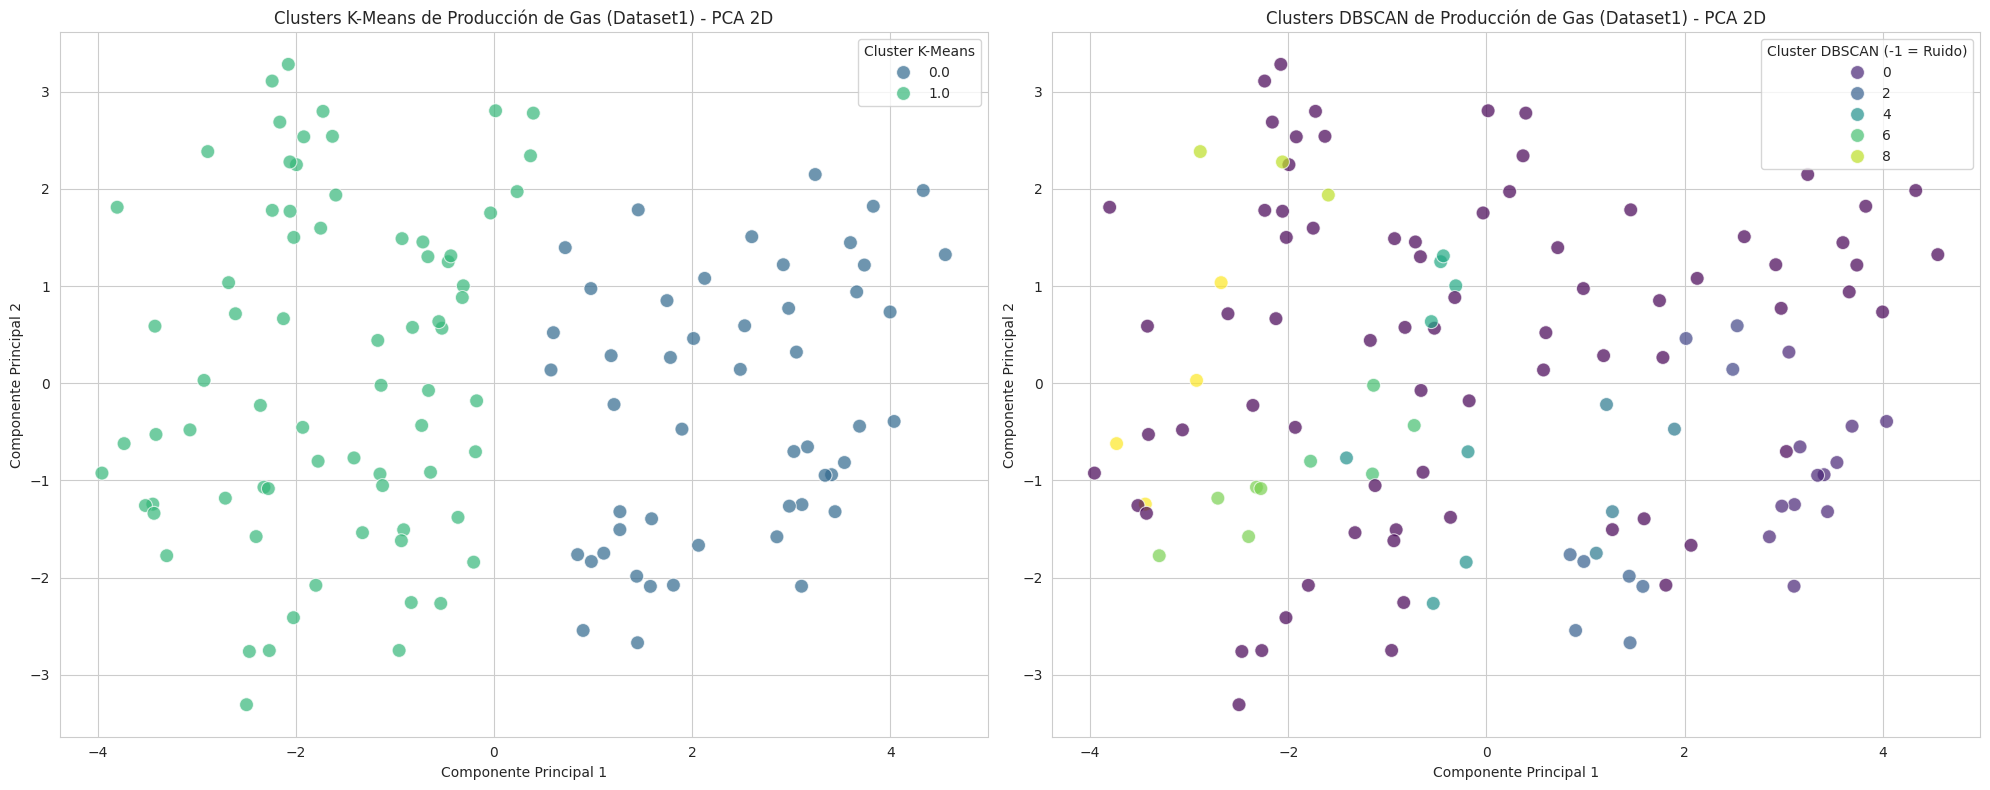

In [ ]:
# Visualización de Clusters con K-Means y DBSCAN

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Gráfico de Clusters (K-Means)
plt.subplot(1, 2, 1)
sns.scatterplot(x='pca1', y='pca2', hue='kmeans_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters K-Means de Producción de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')

# Gráfico de Clusters (DBSCAN)
plt.subplot(1, 2, 2)
sns.scatterplot(x='pca1', y='pca2', hue='dbscan_cluster', data=df1, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters DBSCAN de Producción de Gas (Dataset1) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')

plt.tight_layout()
plt.show()

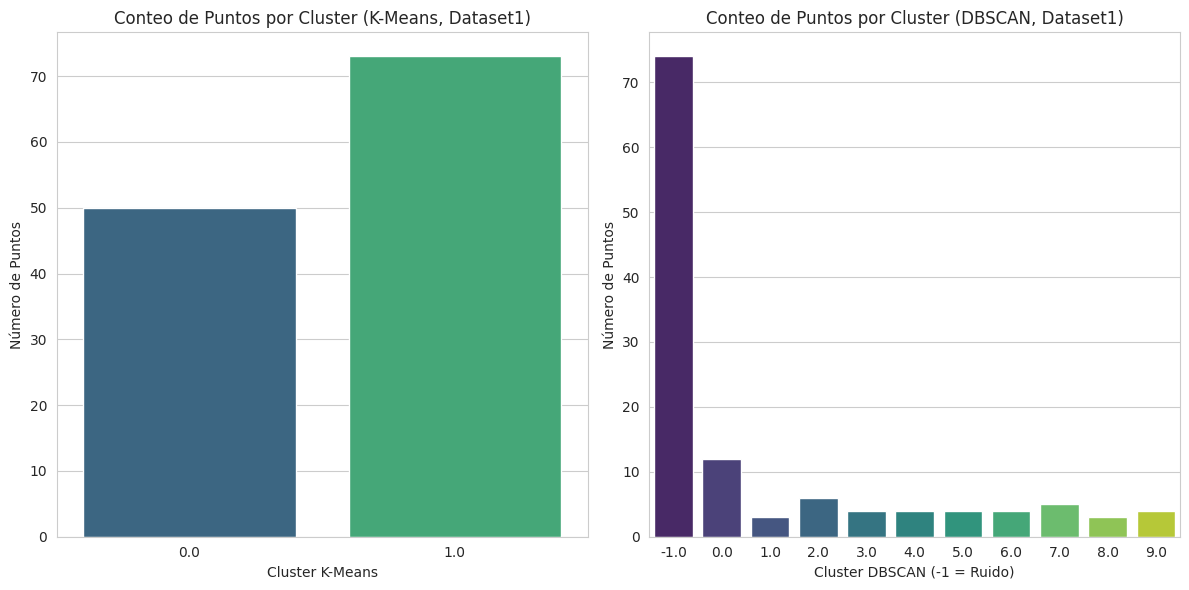

In [ ]:
# Conteo de Puntos por Clusters segun Modelo

import pandas as pd
import matplotlib.pyplot as plt

#Seleccionar solo los clusters
df1_clustered = df1.loc[df_for_models.index].copy()

# Comparación de Conteo de Clusters
plt.figure(figsize=(12, 6))

# Conteo para K-Means
plt.subplot(1, 2, 1)
kmeans_counts = df1_clustered['kmeans_cluster'].value_counts().sort_index()
sns.barplot(x=kmeans_counts.index, y=kmeans_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (K-Means, Dataset1)')
plt.xlabel('Cluster K-Means')
plt.ylabel('Número de Puntos')

# Conteo para DBSCAN
plt.subplot(1, 2, 2)
dbscan_counts = df1_clustered['dbscan_cluster'].value_counts().sort_index()
sns.barplot(x=dbscan_counts.index, y=dbscan_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (DBSCAN, Dataset1)')
plt.xlabel('Cluster DBSCAN (-1 = Ruido)')
plt.ylabel('Número de Puntos')

plt.tight_layout()
plt.show()

### 🧾 **Conclusiones Generales del Dataset1**

El análisis conjunto de K-Means y DBSCAN permitió revelar patrones complementarios en la evolución de la producción de gas en Argentina.

K-Means expuso una visión clara y estructurada, diferenciando dos grandes etapas:

* Una fase tradicional, asociada a los primeros años del período, dominada por cuencas convencionales.

* Una fase moderna, marcada por el auge de Neuquina y la expansión del shale y tight gas.

DBSCAN, en cambio, brindó una perspectiva más detallada, identificando múltiples clústeres que capturan fases de transición más sutiles, con matices temporales y productivos, y revelando microestructuras que reflejan la evolución gradual del sector. Además, permitió detectar puntos de ruido que representan casos atípicos a lo largo del tiempo.

Ambos enfoques, el macroscópico de K-Means y el granular de DBSCAN, se complementan para ofrecer una lectura integral de las dinámicas históricas y estructurales de la industria del gas natural.

---

## 2. Clustering con Dataset 2: Producción de Pozos No Convencionales  

El objetivo es segmentar pozos para **identificar grupos con características de producción o geográficas similares**, y detectar pozos atípicos (outliers).

Aplicaremos:

- **K-Means**  
- **DBSCAN**  
- **GMM (Gaussian Mixture Models)**


###🔍 Carga e Inspección del Dataset 2
Cargamos el dataset, revisamos columnas, tipos de datos y valores nulos. Filtramos los últimos 10 años para capturar las tendencias más recientes, y se renombraron algunas columnas.

In [ ]:
df2 = pd.read_csv('/content/produccin-de-pozos-de-gas-y-petrleo-no-convencional.csv')

In [ ]:
df2.head()

,idempresa,anio,mes,idpozo,prod_pet,prod_gas,prod_agua,iny_agua,iny_gas,iny_co2,...,cuenca,provincia,coordenadax,coordenaday,tipo_de_recurso,proyecto,clasificacion,subclasificacion,sub_tipo_recurso,fecha_data
0,YSUR,2018,1,132488,0.0,171.937,0.00,0.0,0.0,0.0,...,NEUQUINA,Rio Negro,-67.864960,-39.016722,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2018-01-31
1,YSUR,2017,1,130021,0.0,245.850,16.68,0.0,0.0,0.0,...,NEUQUINA,Neuquén,-69.733102,-39.024859,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2017-01-31
2,YSUR,2018,1,132487,0.0,514.696,17.00,0.0,0.0,0.0,...,NEUQUINA,Rio Negro,-67.837875,-39.019313,NO CONVENCIONAL,Sin Proyecto,EXPLOTACION,DESARROLLO,TIGHT,2018-01-31
3,YSUR,2015,1,137212,0.0,422.110,0.00,0.0,0.0,0.0,...,NEUQUINA,Neuquén,-69.255971,-38.860779,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2015-01-31
4,YSUR,2018,1,132361,0.0,217.103,7.30,0.0,0.0,0.0,...,NEUQUINA,Neuquén,-69.231360,-38.869270,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2018-01-31


In [ ]:
df2.shape

(345382, 40)

In [ ]:
df2.columns

Index(['idempresa', 'anio', 'mes', 'idpozo', 'prod_pet', 'prod_gas',
       'prod_agua', 'iny_agua', 'iny_gas', 'iny_co2', 'iny_otro', 'tef',
       'vida_util', 'tipoextraccion', 'tipoestado', 'tipopozo',
       'observaciones', 'fechaingreso', 'rectificado', 'habilitado',
       'idusuario', 'empresa', 'sigla', 'formprod', 'profundidad', 'formacion',
       'idareapermisoconcesion', 'areapermisoconcesion', 'idareayacimiento',
       'areayacimiento', 'cuenca', 'provincia', 'coordenadax', 'coordenaday',
       'tipo_de_recurso', 'proyecto', 'clasificacion', 'subclasificacion',
       'sub_tipo_recurso', 'fecha_data'],
      dtype='object')

#### Procesamiento de Datos

In [ ]:
# Copiar el dataframe
df2_copy = df2.copy()

In [ ]:
# Filas y columnas
df2_copy.shape

(345382, 40)

**Filtrar últimos 10 años**

In [ ]:
# Agregar una nueva columna que se llame 'fecha'

import pandas as pd
df2_copy['fecha'] = df2_copy['anio'].astype(str) + '-' + df2_copy['mes'].astype(str).str.zfill(2) + '-01'
df2_copy['fecha'] = pd.to_datetime(df2_copy['fecha'])

In [ ]:
# Ordenar por fecha
df2_copy = df2_copy.sort_values('fecha')

# Filtrar por rango de años (2006 a 2024)
df2_copy = df2_copy[(df2_copy['fecha'].dt.year >= 2006) &
                   (df2_copy['fecha'].dt.year <= 2024)]

In [ ]:
# Filtrar últimos 10 años
df2_copy = df2_copy[df2_copy['fecha'] >= '2014-01-01']

In [ ]:
#Rango de Fechas
print(f"Rango de fechas del Dataset2 filtrado: {df2_copy['fecha'].min().strftime('%Y-%m')} a {df2_copy['fecha'].max().strftime('%Y-%m')}")

Rango de fechas del Dataset2 filtrado: 2014-01 a 2024-12


**Filtrar Pozos Gasíferos**

Mantener solo los datos donde en mi feature `'tipopozo'` solo conserve el valor 'Gasífero'. Esto se debe a que el Dataset2 tiene información sobre Gas y Petroleo no convencional, pero solo conservamos los gasiferos que son pertinentes para nuestro análisis

In [ ]:
# Obtener todos los valores únicos de la columna 'tipopozo'
valores_unicos = df2_copy['tipopozo'].unique()

# Imprimir los valores únicos
print(f"Valores únicos en la columna '{'tipopozo'}':")
for valor in valores_unicos:
    print(valor)

Valores únicos en la columna 'tipopozo':
Gasífero
Otro tipo
Petrolífero
nan
Sumidero
Inyección de Gas
Inyección de Agua


In [ ]:
# Filtrar los datos que en 'tipopozo' el valor sea 'Gasífero'

df2_copy = df2_copy[df2_copy['tipopozo'] == 'Gasífero'].copy()

print("\nConteo de valores en 'tipopozo' después del filtro:")
print(df2_copy['tipopozo'].value_counts())


Conteo de valores en 'tipopozo' después del filtro:
tipopozo
Gasífero    173541
Name: count, dtype: int64


In [ ]:
# Verificar valores de 'tipopozo'

print(df2_copy['tipopozo'].unique())

['Gasífero']


### 🧮 Selección de Variables

Se incluyen variables como:

- Variables de Producción
- Variables Geográficas
- Variables Categóricas


**Identificación de Variables Actuales**

In [ ]:
# Verificar columnas presentes
df2_copy.columns

Index(['idempresa', 'anio', 'mes', 'idpozo', 'prod_pet', 'prod_gas',
       'prod_agua', 'iny_agua', 'iny_gas', 'iny_co2', 'iny_otro', 'tef',
       'vida_util', 'tipoextraccion', 'tipoestado', 'tipopozo',
       'observaciones', 'fechaingreso', 'rectificado', 'habilitado',
       'idusuario', 'empresa', 'sigla', 'formprod', 'profundidad', 'formacion',
       'idareapermisoconcesion', 'areapermisoconcesion', 'idareayacimiento',
       'areayacimiento', 'cuenca', 'provincia', 'coordenadax', 'coordenaday',
       'tipo_de_recurso', 'proyecto', 'clasificacion', 'subclasificacion',
       'sub_tipo_recurso', 'fecha_data', 'fecha'],
      dtype='object')

**Selección de Variables para los Modelos**

Incluiremos variables de producción, geográficas y categóricas:

- **Variables de Producción (`prod_gas`, `prod_pet`, `prod_agua`):** Son las métricas clave para entender el rendimiento de un pozo. Incluir petróleo y agua es relevante, ya que su producción conjunta con gas puede indicar diferentes tipos de yacimientos o eficiencias de extracción.

- **Variables Geográficas (`coordenady`,`coordenadax`):** Son fundamentales para el clustering espacial. La cercanía geográfica puede implicar similitudes en las características geológicas del subsuelo o en las prácticas operacionales.

- **Variables Categóricas (`cuenca`, `provincia`, `sub_tipo_recurso`, `subclasificacion`):** Aportan información contextual crítica sobre la ubicación geológica, administrativa y las características específicas del recurso (shale, tight, etc.), lo que puede diferenciar significativamente el comportamiento de los pozos.

In [ ]:
# Seleccionar características para clustering
features_2 = [
    'prod_gas',
    'prod_pet',
    'prod_agua',
    'coordenaday',
    'coordenadax',
    'cuenca',
    'provincia',
    'sub_tipo_recurso',
    'subclasificacion'
]

# Verificar si todas las columnas existen antes de continuar
missing_cols_df2_copy = [col for col in features_2 if col not in df2_copy.columns]
if missing_cols_df2_copy:
    print(f"Advertencia: Las siguientes columnas no se encontraron en df2_non_conv_gas y serán omitidas o se necesitará un paso previo para crearlas: {missing_cols_df2}")
    features_2 = [col for col in features_2 if col in df2_copy.columns]

df2_copy = df2_copy[features_2].copy()

print(f"Características seleccionadas para Dataset2: {df2_copy.columns.tolist()}")

Características seleccionadas para Dataset2: ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax', 'cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']


### 🧼 Preprocesamiento de Datos  

#### 1. Manejo de Nulos  

Revisamos y tratamos posibles valores nulos que puedan afectar los modelos.

In [ ]:
def calcular_nulos_y_porcentaje(df):

    nulos = df.isnull().sum()
    porcentaje_nulos = (nulos / len(df)) * 100
    nulos_df = pd.DataFrame({'Nulos': nulos, 'Porcentaje Nulos (%)': porcentaje_nulos})
    return nulos_df

In [ ]:
calcular_nulos_y_porcentaje(df2_copy)

,Nulos,Porcentaje Nulos (%)
prod_gas,0,0.000000
prod_pet,0,0.000000
prod_agua,0,0.000000
coordenaday,0,0.000000
coordenadax,0,0.000000
cuenca,0,0.000000
provincia,0,0.000000
sub_tipo_recurso,206,0.118704
subclasificacion,528,0.304251


In [ ]:
# Verificar valores de 'sub_tipo_recurso'
print(df2_copy['sub_tipo_recurso'].unique())

['TIGHT' 'SHALE' nan]


In [ ]:
# Verificar valores de 'subclasificacion'
print(df2_copy['subclasificacion'].unique())

['DESARROLLO' 'AVANZADA' 'EXPLORACION' 'EXTENSION' nan
 'EXPLORATORIO PROFUNDO']


Dada la muy baja proporción de valores nulos en las variables categóricas (sub_tipo_recurso con 0.11% y subclasificacion con 0.30%), y en pos de preservar los datos, aplicamos la estrategia de imputación por moda.

In [ ]:
# Imputar nulos en 'sub_tipo_recurso' y 'subclasificacion' con la moda
for col in ['sub_tipo_recurso', 'subclasificacion']:
    mode_value = df2_copy[col].mode()[0]
    df2_copy[col].fillna(mode_value, inplace=True)

# Verificar si quedan nulos en estas columnas
print("\nConteo de nulos después de la imputación:")
print(df2_copy[['sub_tipo_recurso', 'subclasificacion']].isnull().sum())

# Verificar los valores únicos de las columnas después de la imputación para asegurar que la moda se aplicó correctamente
print("\nValores únicos de 'sub_tipo_recurso' después de la imputación:")
print(df2_copy['sub_tipo_recurso'].unique())

print("\nValores únicos de 'subclasificacion' después de la imputación:")
print(df2_copy['subclasificacion'].unique())


Conteo de nulos después de la imputación:
sub_tipo_recurso    0
subclasificacion    0
dtype: int64

Valores únicos de 'sub_tipo_recurso' después de la imputación:
['TIGHT' 'SHALE']

Valores únicos de 'subclasificacion' después de la imputación:
['DESARROLLO' 'AVANZADA' 'EXPLORACION' 'EXTENSION' 'EXPLORATORIO PROFUNDO']


In [ ]:
df2_copy.dtypes

,0
prod_gas,float64
prod_pet,float64
prod_agua,float64
coordenaday,float64
coordenadax,float64
cuenca,object
provincia,object
sub_tipo_recurso,object
subclasificacion,object


#### 2. Detección y Manejo de Outliers  

Identificamos y analizamos valores atípicos. Definimos un criterio para el manejo de estos outliers.


**Outliers de Variables de Producción**

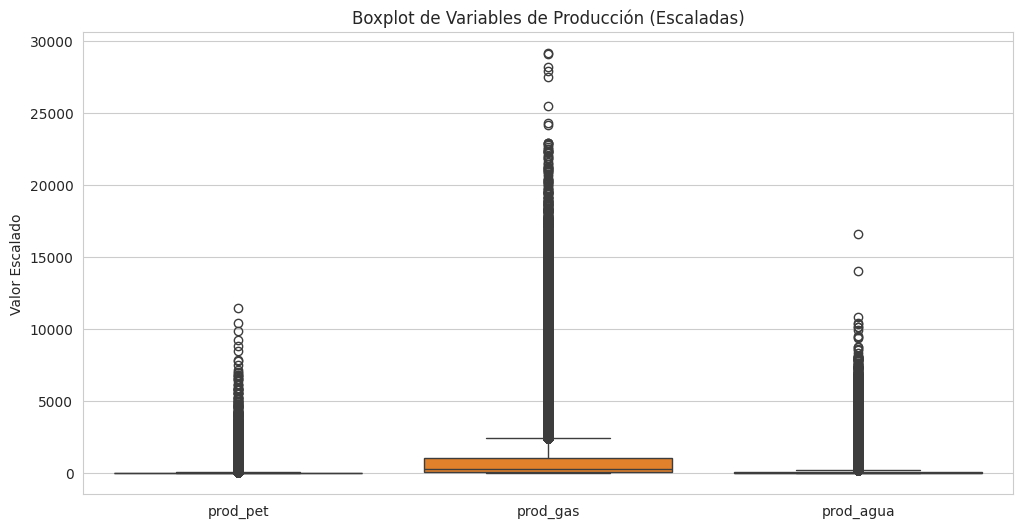

In [ ]:
# Outliers de Variables de Producción: 'prod_pet', 'prod_gas', 'prod_agua'

plt.figure(figsize=(12, 6))
sns.boxplot(data=df2_copy[['prod_pet', 'prod_gas', 'prod_agua']])
plt.title('Boxplot de Variables de Producción (Escaladas)')
plt.ylabel('Valor Escalado')
plt.show()


In [ ]:
# Identificar Outliers de las Variables de Producción

import pandas as pd
def find_outliers_iqr(df2_copy, columns):

    outlier_indices = {}
    for col in columns:
        Q1 = df2_copy[col].quantile(0.25)
        Q3 = df2_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Encontrar los índices de los outliers
        outlier_indices[col] = df2_copy[(df2_copy[col] < lower_bound) | (df2_copy[col] > upper_bound)].index.tolist()
    return outlier_indices

# Variables a analizar para outliers
outlier_vars = ['prod_pet', 'prod_gas', 'prod_agua']

# Identificar outliers usando la función
outliers_dict = find_outliers_iqr(df2_copy, outlier_vars)

# Lista para almacenar el total de outliers encontrados (contando índices únicos)
all_outlier_indices = []

# Iterar sobre las columnas numéricas para identificar outliers
for col, indices in outliers_dict.items():
    print(f"Outliers encontrados en '{col}' usando IQR: {len(indices)}")
    all_outlier_indices.extend(indices)

# Calcular el total de puntos de datos
total_data_points = df2_copy.shape[0]

# Calcular el total de outliers únicos (contando cada fila con al menos un outlier una vez)
total_unique_outliers = len(set(all_outlier_indices))

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers = (total_unique_outliers / total_data_points) * 100 if total_data_points > 0 else 0

# Imprimir los resultados
print("\nResultados del Análisis de Outliers:")
print(f"Total de outliers identificados (índices únicos): {total_unique_outliers}")
print(f"Total de datos en el DataFrame procesado: {total_data_points}")
print(f"Porcentaje de outliers sobre el total de datos: {percentage_outliers:.2f}%")

Outliers encontrados en 'prod_pet' usando IQR: 27153
Outliers encontrados en 'prod_gas' usando IQR: 20584
Outliers encontrados en 'prod_agua' usando IQR: 24161

Resultados del Análisis de Outliers:
Total de outliers identificados (índices únicos): 44634
Total de datos en el DataFrame procesado: 173541
Porcentaje de outliers sobre el total de datos: 25.72%


Para las Variables de Producción (prod_pet, prod_gas, prod_agua), donde tenemos un 25.72% de outliers identificados por IQR, la decisión de cómo manejarlos es crucial, ya que estos valores extremos pueden tener un impacto significativo en los algoritmos de clustering.

Por este motivo decidimos realizar una **transformación Logarítmica y aplicar StandardScaler** para asi reducir a influencia de outliers pero conservar los datos.

*(Apicado en la codificación de Variables Númericas)*

**Outliers de Variables Geográficas**

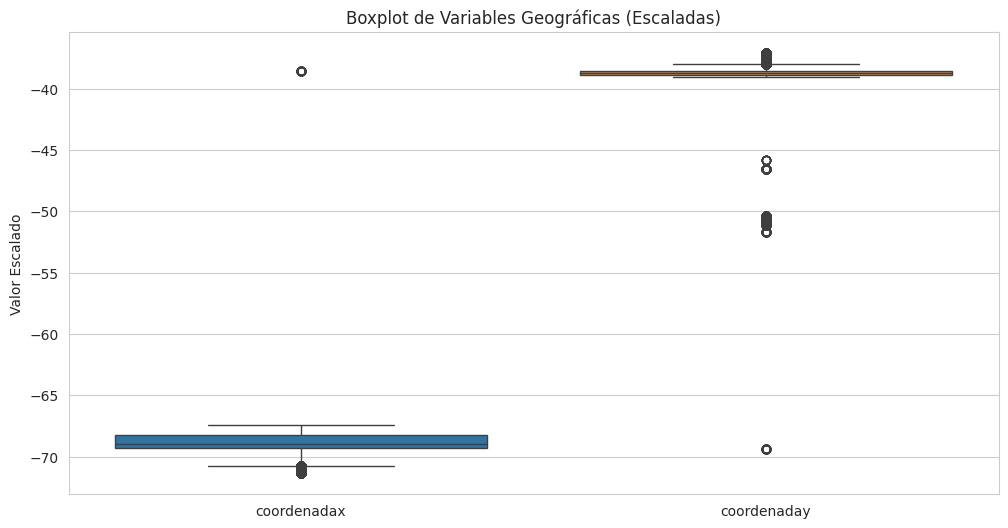

In [ ]:
# Outliers de Variables de Geográficas

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(data=df2_copy[['coordenadax', 'coordenaday']])
plt.title('Boxplot de Variables Geográficas (Escaladas)')
plt.ylabel('Valor Escalado')
plt.show()

In [ ]:
# Identificar Outliers de las Variables Geográficas

import pandas as pd
def find_outliers_iqr(df2_copy, columns):

    outlier_indices = {}
    for col in columns:
        Q1 = df2_copy[col].quantile(0.25)
        Q3 = df2_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Encontrar los índices de los outliers
        outlier_indices[col] = df2_copy[(df2_copy[col] < lower_bound) | (df2_copy[col] > upper_bound)].index.tolist()
    return outlier_indices

# Variables a analizar para outliers geográficos
outlier_vars_geo = ['coordenadax', 'coordenaday']

# Identificar outliers usando la función
outliers_dict_geo = find_outliers_iqr(df2_copy, outlier_vars_geo)

# Lista para almacenar el total de outliers encontrados (contando índices únicos)
all_outlier_indices_geo = []

# Iterar sobre las columnas numéricas para identificar outliers
for col, indices in outliers_dict_geo.items():
    print(f"Outliers encontrados en '{col}' usando IQR: {len(indices)}")
    all_outlier_indices_geo.extend(indices)

# Calcular el total de puntos de datos
total_data_points_geo = df2_copy.shape[0]

# Calcular el total de outliers únicos (contando cada fila con al menos un outlier una vez)
total_unique_outliers_geo = len(set(all_outlier_indices_geo))

# Calcular el porcentaje de outliers sobre el total de puntos de datos
percentage_outliers_geo = (total_unique_outliers_geo / total_data_points_geo) * 100 if total_data_points_geo > 0 else 0

# Imprimir los resultados
print("\nResultados del Análisis de Outliers Geográficos:")
print(f"Total de outliers identificados en columnas geográficas: {total_unique_outliers_geo}")
print(f"Total de datos en el DataFrame procesado: {total_data_points_geo}")
print(f"Porcentaje de outliers sobre el total de datos geográficos: {percentage_outliers_geo:.2f}%")

Outliers encontrados en 'coordenadax' usando IQR: 2859
Outliers encontrados en 'coordenaday' usando IQR: 19700

Resultados del Análisis de Outliers Geográficos:
Total de outliers identificados en columnas geográficas: 19700
Total de datos en el DataFrame procesado: 173541
Porcentaje de outliers sobre el total de datos geográficos: 11.35%


Las coordenadas geográficas no son métricas de "rendimiento" como la producción de gas o petróleo. Son ubicaciones. Un pozo ubicado lejos del "centro" de la mayoría de los pozos no es necesariamente un "error" o un valor anómalo en el mismo sentido que una producción extremadamente alta o baja.

Por este motivo decidimos mantener estos "outliers" geográficos. Eliminarlos sería contraproducente para el objetivo de nuestro análisis: Descubrir Patrones Geográficos.

#### 3. Escalado de Variables Numéricas (StandardScaler)  

Usamos **Z-score** para escalar variables de producción `prod_gas`, `prod_pet` y `prod_agua`, y las variables geograficas `coordenadax` y `coordenaday` son variables númericas por lo que aplicaremos el StandardScaler.

In [ ]:
# Variables Númericas
numeric_cols = df2_copy.select_dtypes(include=np.number).columns.tolist()
print("Variables numéricas:")
numeric_cols

Variables numéricas:


['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

#### 4. Codificación de Variables Categóricas (OneHotEncoder)  

Convertimos variables categóricas, como `'cuenca'`, `'provincia'`, `'sub_tipo_recurso'`, `'subclasificacion'` a formato numérico utilizando OneHotEncoder.

In [ ]:
# Variables Categóricas
object_cols = df2_copy.select_dtypes(include='object').columns.tolist()
print("Variables categóricas (Object):")
object_cols

Variables categóricas (Object):


['cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']

In [ ]:
# Identificar columnas numéricas y categóricas
numerical_features_2 = [col for col in df2_copy.columns if df2_copy[col].dtype in ['int32', 'int64', 'float64']]
categorical_features_2 = [col for col in df2_copy.columns if df2_copy[col].dtype in ['object']]

print("\nColumnas Numéricas identificadas:", numerical_features_2)
print("Columnas Categóricas identificadas:", categorical_features_2)


Columnas Numéricas identificadas: ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']
Columnas Categóricas identificadas: ['cuenca', 'provincia', 'sub_tipo_recurso', 'subclasificacion']


In [ ]:
# Dividir columnas numéricas de producción y geograficas
production_features = ['prod_pet', 'prod_gas', 'prod_agua']
geographic_features = ['coordenadax', 'coordenaday']

In [ ]:
# Transformación logarítmica para las variables de producción
log_transformer = FunctionTransformer(np.log1p, validate=True)

In [ ]:
# Preprocesamiento con Pipeline
preprocessor_2 = ColumnTransformer(
    transformers=[
        # Aplicar logaritmo y luego StandardScaler a las variables de producción
        ('prod_num_log_scaled',
         Pipeline([
             ('log', log_transformer),
             ('scaler', StandardScaler())
         ]),
         ['prod_pet', 'prod_gas', 'prod_agua']),

        # Aplicar StandardScaler a las variables geográficas
        ('geo_num_scaled', StandardScaler(), ['coordenadax', 'coordenaday']),

        # Aplicar OneHotEncoder a las variables categóricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_2)
    ],
    remainder='passthrough'
)

# Aplicar el preprocesamiento
df2_processed_array = preprocessor_2.fit_transform(df2_copy)

# Obtener los nombres de las características después del preprocesamiento
feature_names_prod = [f"log_scaled_{col}" for col in ['prod_pet', 'prod_gas', 'prod_agua']]
feature_names_geo = [f"scaled_{col}" for col in ['coordenadax', 'coordenaday']]
feature_names_cat = preprocessor_2.named_transformers_['cat'].get_feature_names_out(categorical_features_2)

# Combinar los nombres de las columnas procesadas
processed_feature_names_2 = feature_names_prod + feature_names_geo + list(feature_names_cat)

# Convierte el array procesado de nuevo en un DataFrame
df2_processed = pd.DataFrame(df2_processed_array, columns=processed_feature_names_2, index=df2_copy.index)

print(f"Dimensiones de los datos procesados: {df2_processed.shape}")
print(f"Columnas del DataFrame procesado: {df2_processed.columns.tolist()}")

Dimensiones de los datos procesados: (173541, 20)
Columnas del DataFrame procesado: ['log_scaled_prod_pet', 'log_scaled_prod_gas', 'log_scaled_prod_agua', 'scaled_coordenadax', 'scaled_coordenaday', 'cuenca_AUSTRAL', 'cuenca_GOLFO SAN JORGE', 'cuenca_NEUQUINA', 'provincia_Chubut', 'provincia_Mendoza', 'provincia_Neuquén', 'provincia_Rio Negro', 'provincia_Santa Cruz', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT', 'subclasificacion_AVANZADA', 'subclasificacion_DESARROLLO', 'subclasificacion_EXPLORACION', 'subclasificacion_EXPLORATORIO PROFUNDO', 'subclasificacion_EXTENSION']


In [ ]:
df2_processed.isnull().sum()

,0
log_scaled_prod_pet,0
log_scaled_prod_gas,2
log_scaled_prod_agua,0
scaled_coordenadax,0
scaled_coordenaday,0
cuenca_AUSTRAL,0
cuenca_GOLFO SAN JORGE,0
cuenca_NEUQUINA,0
provincia_Chubut,0
provincia_Mendoza,0


In [ ]:
# Eliminar los valores nulos de 'log_scaled_prod_gas'

df2_processed.dropna(subset=['log_scaled_prod_gas'], inplace=True)
print("Nulos después de eliminar nulos en 'log_scaled_prod_gas':")
print(df2_processed.isnull().sum())

Nulos después de eliminar nulos en 'log_scaled_prod_gas':
log_scaled_prod_pet                       0
log_scaled_prod_gas                       0
log_scaled_prod_agua                      0
scaled_coordenadax                        0
scaled_coordenaday                        0
cuenca_AUSTRAL                            0
cuenca_GOLFO SAN JORGE                    0
cuenca_NEUQUINA                           0
provincia_Chubut                          0
provincia_Mendoza                         0
provincia_Neuquén                         0
provincia_Rio Negro                       0
provincia_Santa Cruz                      0
sub_tipo_recurso_SHALE                    0
sub_tipo_recurso_TIGHT                    0
subclasificacion_AVANZADA                 0
subclasificacion_DESARROLLO               0
subclasificacion_EXPLORACION              0
subclasificacion_EXPLORATORIO PROFUNDO    0
subclasificacion_EXTENSION                0
dtype: int64


### 🤖 Aplicación de Algoritmos de Clustering

Implementaremos K-Means y DBSCAN para el Dataset 2.

**Reducción de dimensionalidad - PCA**

Debido a la gran cantidad de dimensiones del Dataset2 (20 en total), una de las prácticas para realizar un clustering es reducir la dimensionalidad.

Se llevará a cabo el metodo PCA para la reducción de dimensionalidad de columnas importantes para nuestro analisis.

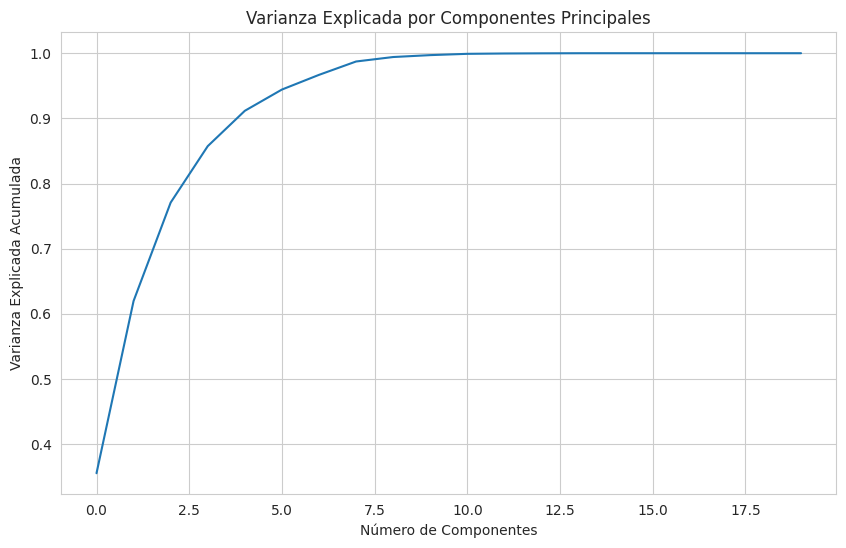

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

 # Copia de df2_processed
df2_clusters = df2_processed.copy()

# Imputar valores perdidos en “log_scaled_prod_gas” con la media
mean_log_scaled_prod_gas = df2_clusters['log_scaled_prod_gas'].mean()
df2_clusters['log_scaled_prod_gas'].fillna(mean_log_scaled_prod_gas, inplace=True)


# Determinar el número óptimo de componentes para PCA
pca = PCA().fit(df2_clusters)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid(True)
plt.show()

In [ ]:
# Elegir cuántos componentes explican una varianza aceptable
n_components_pca = 10

# Aplicar PCA con el número de componentes elegido
pca_final = PCA(n_components=n_components_pca, random_state=42)
df2_clusters_pca = pca_final.fit_transform(df2_clusters)

# Crea un DataFrame con los componentes PCA para el clustering
df2_pca_processed = pd.DataFrame(df2_clusters_pca, index=df2_clusters.index,
                                columns=[f'PC_{i+1}' for i in range(n_components_pca)])

print(f"\nDimensiones de los datos después de PCA: {df2_pca_processed.shape}")
print(f"Varianza explicada por los {n_components_pca} componentes: {pca_final.explained_variance_ratio_.sum():.2f}")


Dimensiones de los datos después de PCA: (173539, 10)
Varianza explicada por los 10 componentes: 1.00


In [ ]:
# Verificar el tipo de datos en df2_pca_processed
df2_pca_processed.dtypes

,0
PC_1,float64
PC_2,float64
PC_3,float64
PC_4,float64
PC_5,float64
PC_6,float64
PC_7,float64
PC_8,float64
PC_9,float64
PC_10,float64


**Transformar Datos a `float32`**

In [ ]:
# Convierte los tipos de datos a float32 para optimizar el uso de memoria, como lo hacías antes
for col in df2_pca_processed.select_dtypes(include=[np.float64]).columns:
    df2_pca_processed[col] = df2_pca_processed[col].astype(np.float32)

print(f"Uso de memoria después de float32: {df2_pca_processed.memory_usage(deep=True).sum() / (1024**3):.4f} GB")

Uso de memoria después de float32: 0.0078 GB


#### 📊 K-Means  

Aplicamos K-Means y determinamos el número óptimo de clusters con:

- **Método del Codo**  
- **Coeficiente de Silueta**

Ambos métodos permiten evaluar la cohesión y separación de los grupos.

In [ ]:
# Ignorar FutureWarning de KMeans que a veces aparece con n_init por defecto
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Preparación de los datos para K-Means ---
# Seleccionamos solo las columnas de los componentes PCA
pca_components_for_kmeans = df2_pca_processed.loc[:, ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10']]

print(f"\n--- Preparando los datos para K-Means ---")
print(f"Dimensiones de los datos para K-Means (componentes PCA): {pca_components_for_kmeans.shape}")
print(f"Uso de memoria de los datos para K-Means: {pca_components_for_kmeans.memory_usage(deep=True).sum() / (1024**3):.2f} GB")
print(f"Tipo de datos (dtype) de las componentes PCA: {pca_components_for_kmeans.dtypes.unique()}")


--- Preparando los datos para K-Means ---
Dimensiones de los datos para K-Means (componentes PCA): (173539, 10)
Uso de memoria de los datos para K-Means: 0.01 GB
Tipo de datos (dtype) de las componentes PCA: [dtype('float32')]



Ejecutando Método del Codo para K-Means...


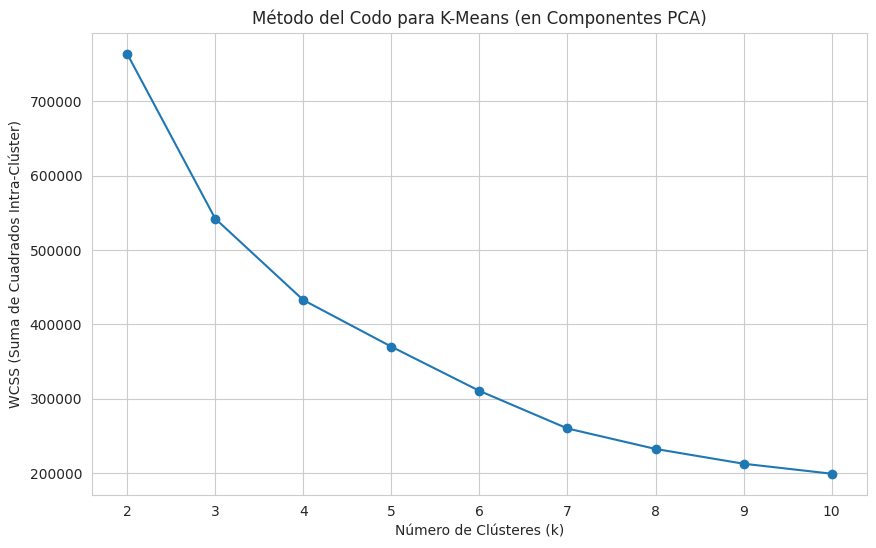

In [ ]:
# 1. Método del Codo para encontrar el k óptimo
print("\nEjecutando Método del Codo para K-Means...")
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(pca_components_for_kmeans)
    wcss.append(kmeans_model.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Método del Codo para K-Means (en Componentes PCA)')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Clúster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

Basándonos en la forma del "codo", el número óptimo de clusters (k) estaría probablemente en 3 o 4,  con una ligera preferencia por `k=3` como el "codo" más marcado.


Calculando Coeficiente de Silueta para K-Means...


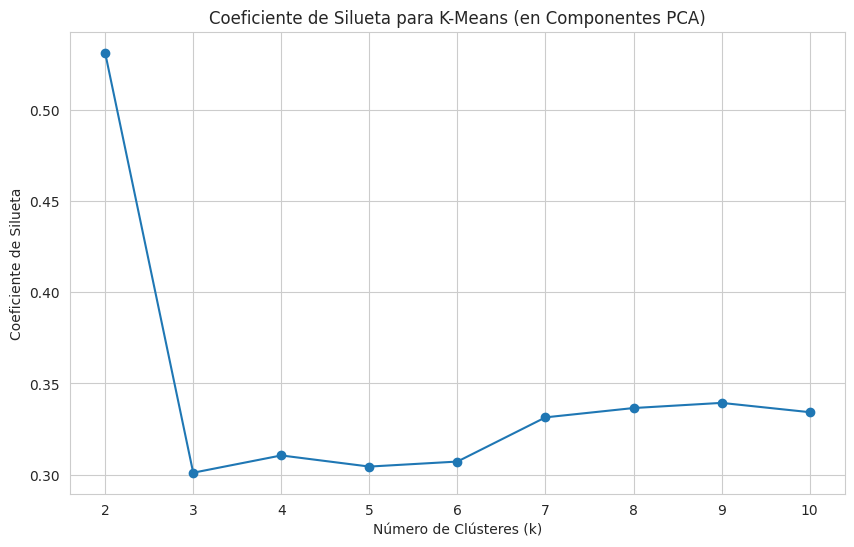

Valores de Coeficiente de Silueta por k: {2: np.float32(0.53147006), 3: np.float32(0.30098775), 4: np.float32(0.3104751), 5: np.float32(0.30436084), 6: np.float32(0.3071123), 7: np.float32(0.33137143), 8: np.float32(0.33648384), 9: np.float32(0.3393159), 10: np.float32(0.33420676)}


In [ ]:
# 2. Coeficiente de Silueta para encontrar el k óptimo
print("\nCalculando Coeficiente de Silueta para K-Means...")
silhouette_scores = []

for k in k_range:
    if k == 1:
        silhouette_scores.append(np.nan)
        continue

    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans_model.fit_predict(pca_components_for_kmeans)

    if len(np.unique(cluster_labels)) > 1:
        score = silhouette_score(pca_components_for_kmeans, cluster_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan)

# Graficar el Coeficiente de Silueta
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Coeficiente de Silueta para K-Means (en Componentes PCA)')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("Valores de Coeficiente de Silueta por k:", {k_val: score for k_val, score in zip(k_range, silhouette_scores)})

In [ ]:
# Aplicar K-Means con el k óptimo elegido
k_optimo_final = 2
print(f"\nEl número de clústeres (k) para K-Means es: {k_optimo_final}")

print(f"\nAplicando K-Means con el k óptimo final elegido: {k_optimo_final}")
kmeans_final = KMeans(n_clusters=k_optimo_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(pca_components_for_kmeans)

# Asignar los clústeres al DataFrame principal df2_pca_processed
df2_pca_processed['kmeans_cluster'] = cluster_labels

print(f"\nDistribución de clústeres K-Means con k={k_optimo_final}:")
print(df2_pca_processed['kmeans_cluster'].value_counts().sort_index())


El número de clústeres (k) para K-Means es: 2

Aplicando K-Means con el k óptimo final elegido: 2

Distribución de clústeres K-Means con k=2:
kmeans_cluster
0    162354
1     11185
Name: count, dtype: int64


El valor más alto del Coeficiente de Silueta se obtiene cuando` k = 2`, con un valor de 0.53147006.

Esto contrasta con la posible elección de k=3 o k=4 que se podía inferir del método del codo. Sin embargo,nos vamos a basar únicamente en el Coeficiente de Silueta, k=2. Esto se debe a que buscamos un equilibrio entre las métricas y la interpretabilidad de los clusters para este análisis.

#### 🌐 DBSCAN  

Exploramos este algoritmo basado en densidad. Las claves:

- **eps**: Radio de vecindad  
- **min_samples**: Mínimo de puntos por vecindad  

Utilizamos el **gráfico de la distancia al K-vecino más cercano** para elegir un buen valor de `eps`.

In [ ]:
# Implementación de DBSCAN
print("\n--- Implementando DBSCAN ---")

X_dbscan = df2_pca_processed.drop(columns=['kmeans_cluster'], errors='ignore').copy()

# Definir min_samples
min_samples_dbscan2_final = 2 * X_dbscan.shape[1]
print(f"Min_samples para DBSCAN (usado en gráfico y final): {min_samples_dbscan2_final}")


--- Implementando DBSCAN ---
Min_samples para DBSCAN (usado en gráfico y final): 20


In [ ]:
# Estimar eps para DBSCAN usando el gráfico de K-distancia
print("Generando Gráfico de Distancia K-Vecino más Cercano para DBSCAN ...")
neighbors = NearestNeighbors(n_neighbors=min_samples_dbscan2_final)
neighbors_fit = neighbors.fit(X_dbscan)
distances, indices = neighbors_fit.kneighbors(X_dbscan)

Generando Gráfico de Distancia K-Vecino más Cercano para DBSCAN ...


In [ ]:
# Ordenar las distancias
distances_sorted = np.sort(distances[:, min_samples_dbscan2_final-1], axis=0)

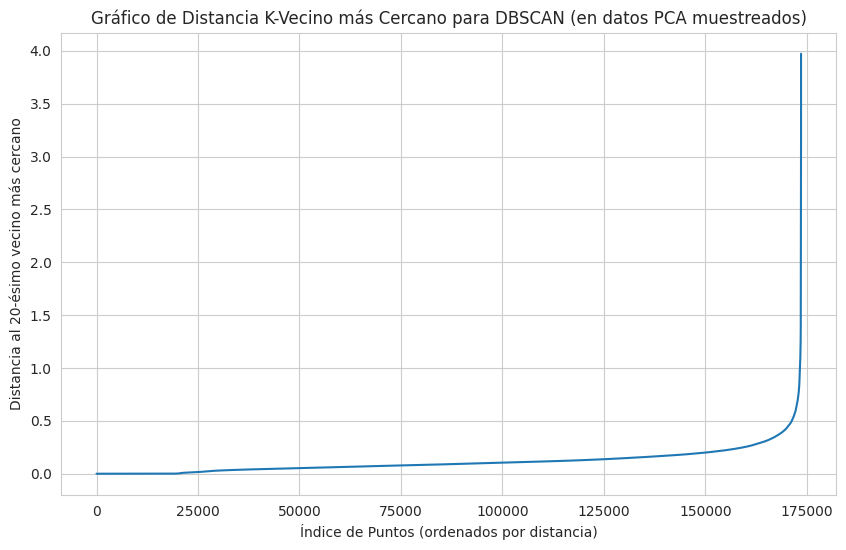

In [ ]:
# Gráfico de Distancia K-Vecino más Cercano para DBSCAN
plt.figure(figsize=(10, 6))
plt.plot(distances_sorted)
plt.xlabel("Índice de Puntos (ordenados por distancia)")
plt.ylabel(f"Distancia al {min_samples_dbscan2_final}-ésimo vecino más cercano")
plt.title("Gráfico de Distancia K-Vecino más Cercano para DBSCAN (en datos PCA muestreados)")
plt.grid(True)
plt.show()

Basándome en la visualización, sugiere un eps en torno a **0.6 - 0.8** para DBSCAN.

Elegimos `eps = 0.8` porque es la opción que mantiene la misma cantidad de clusters pero con menor cantidad de outliers.

In [ ]:
# Selección de eps óptimo
eps_optimo_dbscan2 = 0.8
print(f"\nSe ha definido un eps inicial de {eps_optimo_dbscan2}. ")


Se ha definido un eps inicial de 0.8. 


In [ ]:
# Aplicar DBSCAN con los parámetros seleccionados
dbscan_final = DBSCAN(eps=eps_optimo_dbscan2, min_samples=min_samples_dbscan2_final)

In [ ]:
# Asignar el resultado al DataFrame df2_pca_processed
df2_pca_processed['dbscan_cluster'] = dbscan_final.fit_predict(X_dbscan)
print(f"\nSe ha ejecutado DBSCAN con eps = {eps_optimo_dbscan2} y min_samples = {min_samples_dbscan2_final}.")


Se ha ejecutado DBSCAN con eps = 0.8 y min_samples = 20.


In [ ]:
# Verificar el conteo de clústeres en el DataFrame principal
print("\nConteo de elementos por clúster DBSCAN:")
print(df2_pca_processed['dbscan_cluster'].value_counts().sort_index())
print(f"Nota: El clúster -1 representa outliers (ruido).")


Conteo de elementos por clúster DBSCAN:
dbscan_cluster
-1       183
 0     99682
 1      5800
 2     17829
 3      1917
 4      3209
 5     27005
 6       333
 7      1020
 8       288
 9      9210
 10     1840
 11       20
 12     1372
 13      664
 14     1092
 15      117
 16      229
 17      102
 18      111
 19      133
 20      195
 21      857
 22       92
 23      110
 24       39
 25       70
 26       20
Name: count, dtype: int64
Nota: El clúster -1 representa outliers (ruido).


#### 📈 GMM (Gaussian Mixture Models)

Aplicamos Modelos de Mezcla Gaussiana, una técnica probabilística que asume que los datos provienen de múltiples distribuciones normales.

- Asignación probabilística de pertenencia a cada cluster  
- Estimación de parámetros mediante el algoritmo EM (Expectation-Maximization)

Evaluamos el número óptimo de componentes utilizando los criterios:  
- **BIC** (Bayesian Information Criterion)  
- **AIC** (Akaike Information Criterion)

Estos indicadores penalizan la complejidad del modelo y ayudan a evitar el sobreajuste.


In [ ]:
# Implementación de GMM
print("\n--- Implementando GMM ---")

# Preparación de los datos para GMM
# Seleccionamos solo las columnas de los componentes PCA
pca_components_for_gmm = df2_pca_processed.loc[:, ['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10']]


--- Implementando GMM ---


In [ ]:
# Determinar el número óptimo de componentes para GMM
n_components_range = range(1, 11)
aic = []
bic = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(pca_components_for_gmm)
    aic.append(gmm.aic(pca_components_for_gmm))
    bic.append(gmm.bic(pca_components_for_gmm))

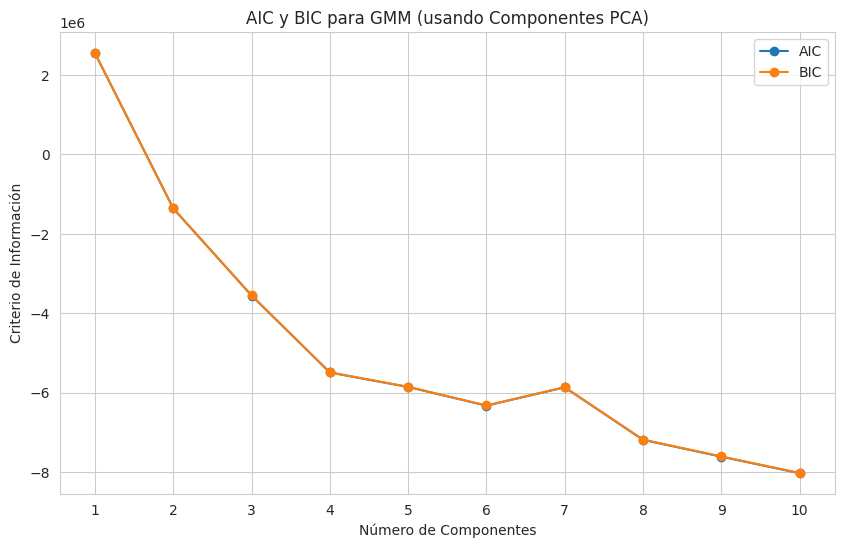

In [ ]:
# Visualización de AIC y BIC para GMM
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic, label='AIC', marker='o')
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Criterio de Información")
plt.title("AIC y BIC para GMM (usando Componentes PCA)")
plt.legend()
plt.xticks(n_components_range)
plt.show()

Basándonos en este gráfico, el valor ideal para `n_optimo_gmm2` es **2**, ya que es el número de componentes que minimiza el Criterio de Información Bayesiano (BIC). Esto sugiere que un modelo GMM con 2 componentes es el que mejor explica los datos con la menor complejidad.

In [ ]:
# Número de componentes
n_optimo_gmm2 = 2
print(f"\nNúmero de componentes óptimo para GMM (elegido manualmente): {n_optimo_gmm2}")


Número de componentes óptimo para GMM (elegido manualmente): 2


In [ ]:
# Aplicar GMM con el número óptimo de componentes seleccionado
gmm2 = GaussianMixture(n_components=n_optimo_gmm2, random_state=42, n_init=10)
gmm2.fit(pca_components_for_gmm)

GaussianMixture(n_components=2, n_init=10, random_state=42)

In [ ]:
# Asignar los clústeres GMM a tu DataFrame principal df2_pca_processed
df2_pca_processed['gmm_cluster'] = gmm2.predict(pca_components_for_gmm)

print(f"\nSe ha ejecutado GMM con {n_optimo_gmm2} componentes.")
print(f"La columna 'gmm_cluster' ha sido añadida a df2_pca_processed.")
print(f"Conteo de elementos por cluster GMM:\n{df2_pca_processed['gmm_cluster'].value_counts().sort_index()}")


Se ha ejecutado GMM con 2 componentes.
La columna 'gmm_cluster' ha sido añadida a df2_pca_processed.
Conteo de elementos por cluster GMM:
gmm_cluster
0    135257
1     38282
Name: count, dtype: int64


### 📉 Análisis Exploratorio y Visualización de Clusters  

Visualizamos los resultados y analizamos promedios por cluster.

#### 📌 K-Means  

- Análisis de Clusters K-Means (Dataset2)

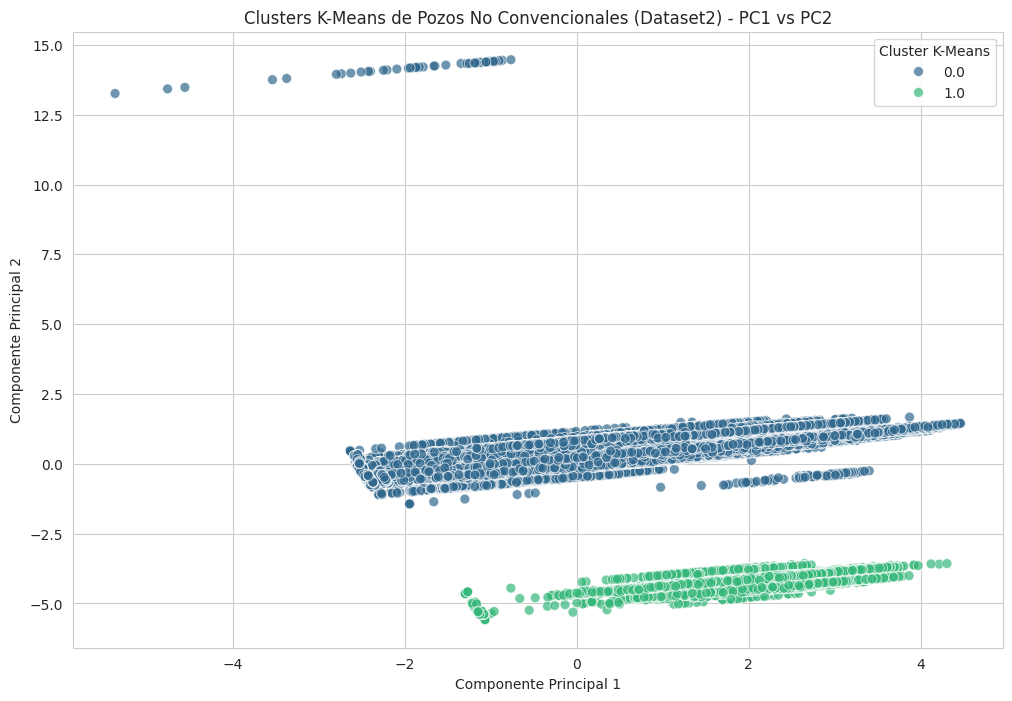

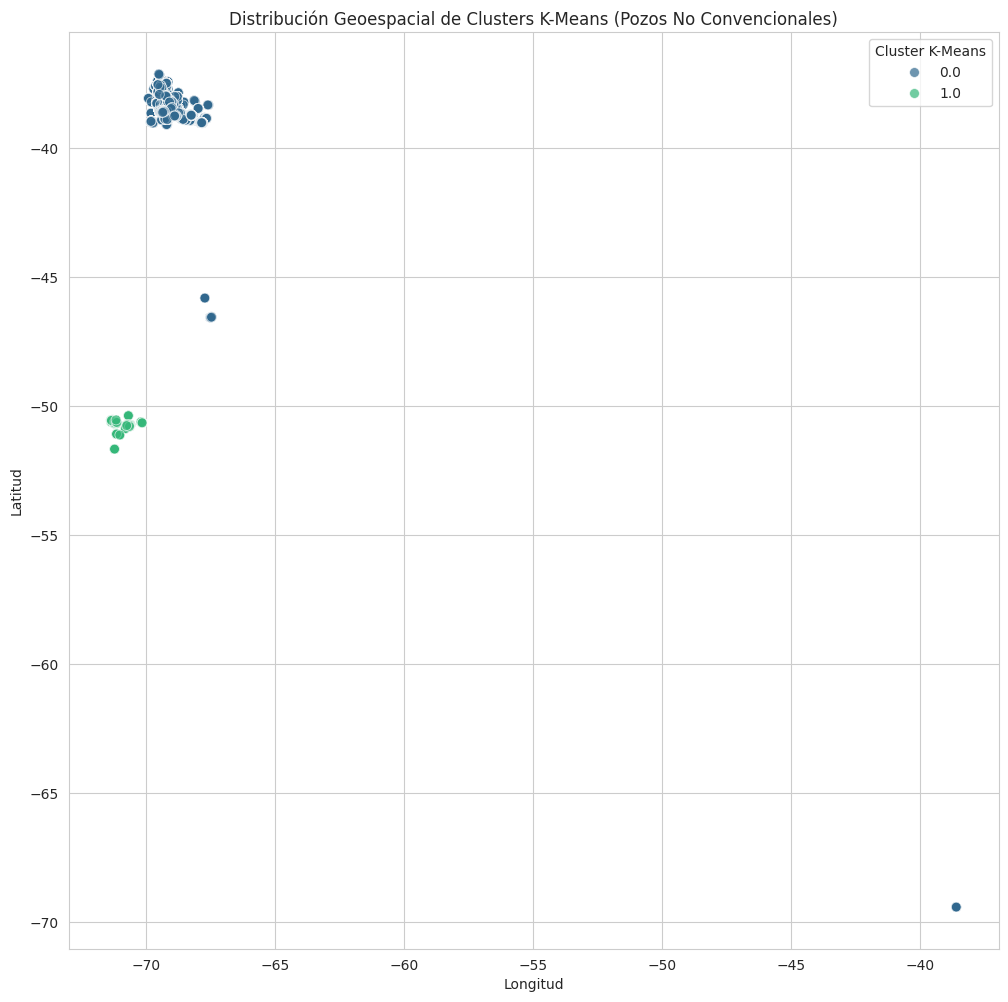


Características promedio por Cluster (K-Means - Dataset2) - Valores Originales:
                   prod_gas   prod_pet   prod_agua  coordenaday  coordenadax
kmeans_cluster                                                              
0.0             1087.937815  55.618457  147.218066   -38.688657   -68.746981
1.0              729.112823  23.070713   60.983357   -50.736652   -70.784902

Proporciones de Variables Categóricas por Cluster (K-Means - Dataset2):

--- Cluster 0.0 ---
  cuenca:
cuenca
NEUQUINA           1.0
GOLFO SAN JORGE    0.0
Name: proportion, dtype: float64
  provincia:
provincia
Neuquén       0.87
Rio Negro     0.12
Mendoza       0.00
Santa Cruz    0.00
Chubut        0.00
Name: proportion, dtype: float64
  sub_tipo_recurso:
sub_tipo_recurso
TIGHT    0.8
SHALE    0.2
Name: proportion, dtype: float64
  subclasificacion:
subclasificacion
DESARROLLO               0.89
AVANZADA                 0.05
EXPLORACION              0.04
EXTENSION                0.01
EXPLORATORIO PROF

In [ ]:
# Análisis de Clusters K-Means (Dataset2)

# Crear un DataFrame con las columnas originales relevantes y los resultados de clusters con PCA
df2_with_clusters = df2_copy.copy()

# Fusionar las etiquetas de clúster y los componentes PCA
df2_with_clusters = df2_with_clusters.merge(
    df2_pca_processed[['PC_1', 'PC_2', 'dbscan_cluster', 'gmm_cluster', 'kmeans_cluster']],
    left_index=True,
    right_index=True,
    how='left'
)

# Seleccionar columnas existentes para la visualización.
df2_with_clusters['pca1_viz_plot'] = df2_with_clusters['PC_1']
df2_with_clusters['pca2_viz_plot'] = df2_with_clusters['PC_2']

# Visualización de Clusters (K-Means) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters K-Means de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.grid(True)
plt.show()

# Visualización Geoespacial de Clusters (K-Means)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribución Geoespacial de Clusters K-Means (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster K-Means')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Características promedio por Cluster (K-Means)
print("\nCaracterísticas promedio por Cluster (K-Means - Dataset2) - Valores Originales:")

# Columnas numéricas originales relevantes para el análisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar de que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas numéricas especificadas se encontró en el DataFrame para el análisis de promedios.")
else:
    cluster_summary_kmeans2 = df2_with_clusters.groupby('kmeans_cluster')[
        existing_numerical_cols
    ].mean()
    print(cluster_summary_kmeans2)

# Análisis de proporciones de variables categóricas por cluster (K-Means)
print("\nProporciones de Variables Categóricas por Cluster (K-Means - Dataset2):")
# Revisar la lista 'categorical_features_2' está definida
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no está definida. No se puede realizar el análisis de variables categóricas.")
else:
    # Revisar que las columnas categóricas existen en df2_with_clusters
    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categóricas especificadas se encontró en el DataFrame para el análisis de proporciones.")
    else:
        for cluster_id in sorted(df2_with_clusters['kmeans_cluster'].unique()):
            cluster_data = df2_with_clusters[df2_with_clusters['kmeans_cluster'] == cluster_id]
            print(f"\n--- Cluster {cluster_id} ---")
            for cat_col in existing_categorical_cols:
                if not cluster_data[cat_col].empty:
                    print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2)}")
                else:
                    print(f"  {cat_col}: No hay datos para este clúster.")

#### **Análisis de Clusters K-Means (Dataset2: Producción de Pozos No Convencionales)**

El modelo K-Means (k=2) permitió segmentar los pozos de gas no convencionales en Argentina en dos grupos bien definidos, diferenciados por ubicación geográfica, tipo de recurso y niveles de productividad.

**Cluster 0.0 – Alta Productividad en Cuenca Neuquina**

* **Ubicación:** 100% de los pozos están en la Cuenca Neuquina, principalmente en Neuquén (87%) y Río Negro (12%).
* **Tipo de Recurso:** Mayoritariamente TIGHT (80%) y en menor medida SHALE (20%).
* **Estado de Desarrollo:** 89% de los pozos están en fase de desarrollo.
* **Producción:** Presenta las producciones promedio más altas de gas, petróleo y agua. Este patrón es consistente con la alta productividad de la formación Vaca Muerta.

**Cluster 1.0 – Baja Productividad en Cuenca Austral**

* **Ubicación:** Todos los pozos se ubican en la Cuenca Austral, provincia de Santa Cruz.
* **Tipo de Recurso:** 100% TIGHT.
* **Estado de Desarrollo:** 82% en fase de desarrollo.
* **Producción:** Significativamente más baja en comparación con el Cluster 0.0 en todas las variables de salida (gas, petróleo y agua).

---

**Conclusión General**

El clustering K-Means permitió identificar dos perfiles productivos claros y geográficamente coherentes dentro del universo de pozos no convencionales: por un lado, pozos de alta productividad en la Cuenca Neuquina con explotación mixta de recursos; por otro, pozos con menor rendimiento en la Cuenca Austral, centrados exclusivamente en tight gas. Esta segmentación proporciona una base sólida para analizar diferencias operativas y orientar estrategias de desarrollo diferenciadas por región.

El análisis de K-Means con **k=2** ha logrado identificar **dos grupos** de pozos no convencionales con características claramente diferenciadas, tanto en términos de producción como de ubicación geográfica y tipo de recurso.

#### 📌 DBSCAN  

- Análisis de Clusters DBSCAN (Dataset2)  
- DBSCAN – Análisis del Ruido

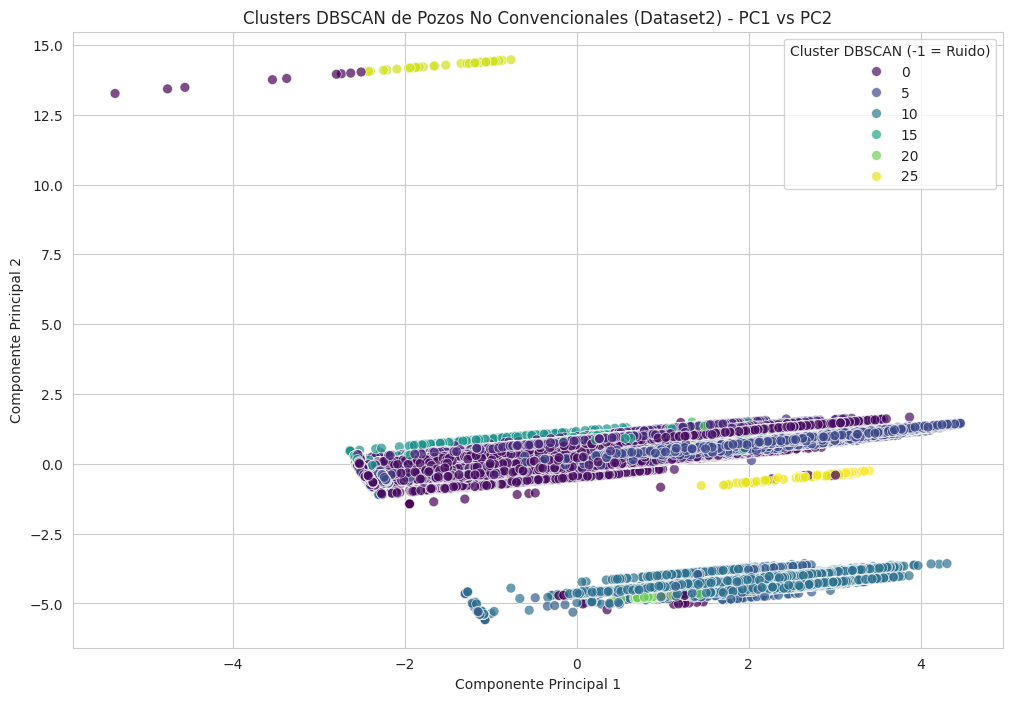

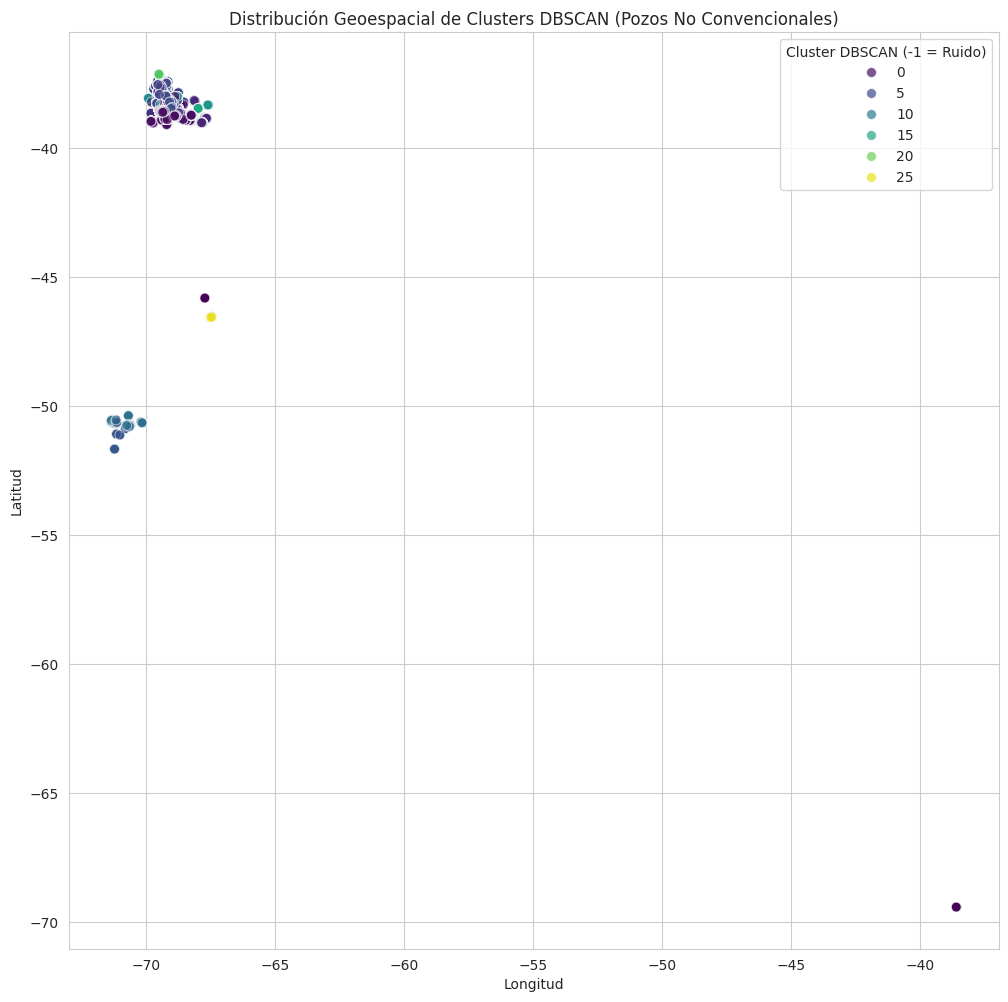


--- Características promedio por Cluster (DBSCAN - Dataset2) - Valores Originales: ---
                   prod_gas    prod_pet   prod_agua  coordenaday  coordenadax
dbscan_cluster                                                               
-1.0             662.246093  147.578484  338.455707   -42.318303   -67.554558
 0.0             645.831258   14.349732   58.535285   -38.739655   -68.794906
 1.0             445.224544   17.367198   57.343407   -38.714238   -68.927345
 2.0             475.938644   95.119760   43.668242   -39.010046   -67.834967
 3.0             696.447347   10.952963   38.670623   -38.702582   -68.971402
 4.0             638.375431   58.856361  117.926312   -38.112696   -69.259407
 5.0            3480.345453  186.586880  585.308595   -38.335669   -69.152906
 6.0               0.000000    0.000000    0.000000   -50.899479   -71.011725
 7.0             564.893316   23.629775   32.260004   -50.728267   -70.828227
 8.0               0.000000    0.000000    0.000000   

In [ ]:
# Visualización de Clusters (DBSCAN) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.grid(True)
plt.show()

# Visualización Geoespacial de Clusters (DBSCAN)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribución Geoespacial de Clusters DBSCAN (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Análisis de Características promedio por Cluster (DBSCAN)
print("\n--- Características promedio por Cluster (DBSCAN - Dataset2) - Valores Originales: ---")

# Columnas numéricas originales relevantes para el análisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas numéricas especificadas se encontró en el DataFrame para el análisis de promedios.")
else:
    if 'dbscan_cluster' in df2_with_clusters.columns:
        cluster_summary_dbscan = df2_with_clusters.groupby('dbscan_cluster')[
            existing_numerical_cols
        ].mean()
        print(cluster_summary_dbscan)
    else:
        print("Advertencia: La columna 'dbscan_cluster' no se encontró en el DataFrame.")


# Análisis de proporciones de variables categóricas por cluster (DBSCAN)
print("\n--- Proporciones de Variables Categóricas por Cluster (DBSCAN - Dataset2): ---")
# Revisar la lista 'categorical_features_2' está definida
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no está definida. No se puede realizar el análisis de variables categóricas.")
else:

    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categóricas especificadas se encontró en el DataFrame para el análisis de proporciones.")
    else:

        if 'dbscan_cluster' in df2_with_clusters.columns:

            for cluster_id in sorted(df2_with_clusters['dbscan_cluster'].unique()):
                cluster_data = df2_with_clusters[df2_with_clusters['dbscan_cluster'] == cluster_id]
                print(f"\n--- Cluster {cluster_id} ---")
                for cat_col in existing_categorical_cols:
                    if not cluster_data[cat_col].empty:

                        print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2).dropna()}")
                    else:
                        print(f"  {cat_col}: No hay datos para este clúster.")
        else:
            print("Advertencia: La columna 'dbscan_cluster' no se encontró en el DataFrame.")

### Análisis de Clusters DBSCAN (Dataset2: Producción de Pozos No Convencionales)

**DBSCAN** segmentó los pozos en 27 clusters más un grupo de outliers, ofreciendo una clasificación más fina que K-Means.

**Clusters por Cuenca y Fase:**

* En la Cuenca Neuquina se destacan clusters con alta producción, especialmente en recursos SHALE y TIGHT en etapas de desarrollo y exploración. También hay clusters con producción baja o nula, identificando pozos en diferentes estados operativos.

* Las Cuencas Austral y Golfo San Jorge muestran clusters con producción variable, desde alta hasta nula, reflejando su diversidad productiva.

**Outliers (Ruido):**

Pozos atípicos con producción variable, que pueden indicar anomalías o errores en datos.

**Aportes clave de DBSCAN:**

* Identificación de micro-regiones geográficas y operativas.
* Detección de pozos con alto potencial productivo y otros con bajo rendimiento.
* Facilita el análisis detallado para decisiones estratégicas más informadas.

**En definitiva, DBSCAN brinda una segmentación más granular y útil para entender la producción de pozos no convencionales que métodos más generales como K-Means.**



**DBSCAN- Análisis de Ruido**

In [ ]:
# Interpretación de Outliers (DBSCAN)
outliers_dbscan2 = df2_with_clusters[df2_with_clusters['dbscan_cluster'] == -1]

print("\n--- Análisis de Ruido (DBSCAN) ---")
if not outliers_dbscan2.empty:
    print(f"Se identificaron {len(outliers_dbscan2)} pozos outliers por DBSCAN.")
    print("Características de los pozos outliers (muestra aleatoria):")

    # Lista de columnas que quieres mostrar para los outliers
    cols_to_show_outliers = [col for col in ['prod_gas', 'prod_pet', 'prod_agua', 'cuenca', 'coordenaday', 'coordenadax'] if col in outliers_dbscan2.columns]


    if cols_to_show_outliers:
        print(outliers_dbscan2[cols_to_show_outliers].sample(min(5, len(outliers_dbscan2)), random_state=42))
    else:
        print("No se encontraron las columnas de producción/geográficas especificadas para mostrar características de outliers.")

else:
    print("No se identificaron outliers por DBSCAN (clúster -1).")


--- Análisis de Ruido (DBSCAN) ---
Se identificaron 183 pozos outliers por DBSCAN.
Características de los pozos outliers (muestra aleatoria):
        prod_gas  prod_pet  prod_agua    cuenca  coordenaday  coordenadax
265138     0.000   0.00000   452.4560  NEUQUINA   -38.526319   -69.496614
100294   303.460  95.25000    52.7300  NEUQUINA   -38.556890   -69.362696
313290   826.970  30.06200     0.0000   AUSTRAL   -50.601610   -71.173080
288925    57.942  60.24817   345.7597  NEUQUINA   -38.148220   -68.807950
311046     0.000  77.96700   151.2420   AUSTRAL   -51.663850   -71.216110


### Análisis de Outliers para DBSCAN

DBSCAN identificó 183 pozos como outliers (ruido), ya que no siguen los patrones densos de producción del resto. Estos pozos presentan comportamientos variados: algunos tienen producción nula de hidrocarburos pero alta de agua (posiblemente pozos inactivos o de descarte), mientras que otros muestran combinaciones inusuales de gas, petróleo y agua.

Los outliers están distribuidos principalmente en las cuencas **Neuquina y Austral**, sin concentración geográfica específica. Sus ubicaciones varían considerablemente en latitud, confirmando que se trata de casos atípicos dispersos.

En conclusión, este grupo representa **pozos con características heterogéneas**, que pueden deberse a errores en los datos o a situaciones reales especiales, por lo que requieren análisis detallado individual.



📌 GMM
- Análisis de Clusters GMM (Dataset2)


--- Visualizando y Analizando Clusters GMM ---


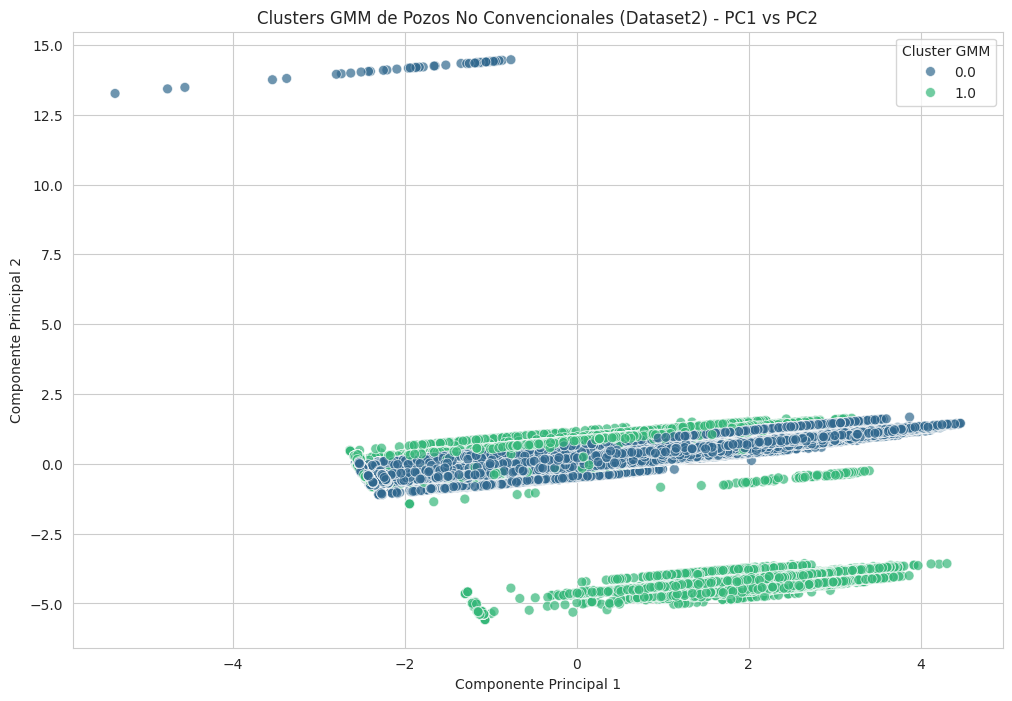

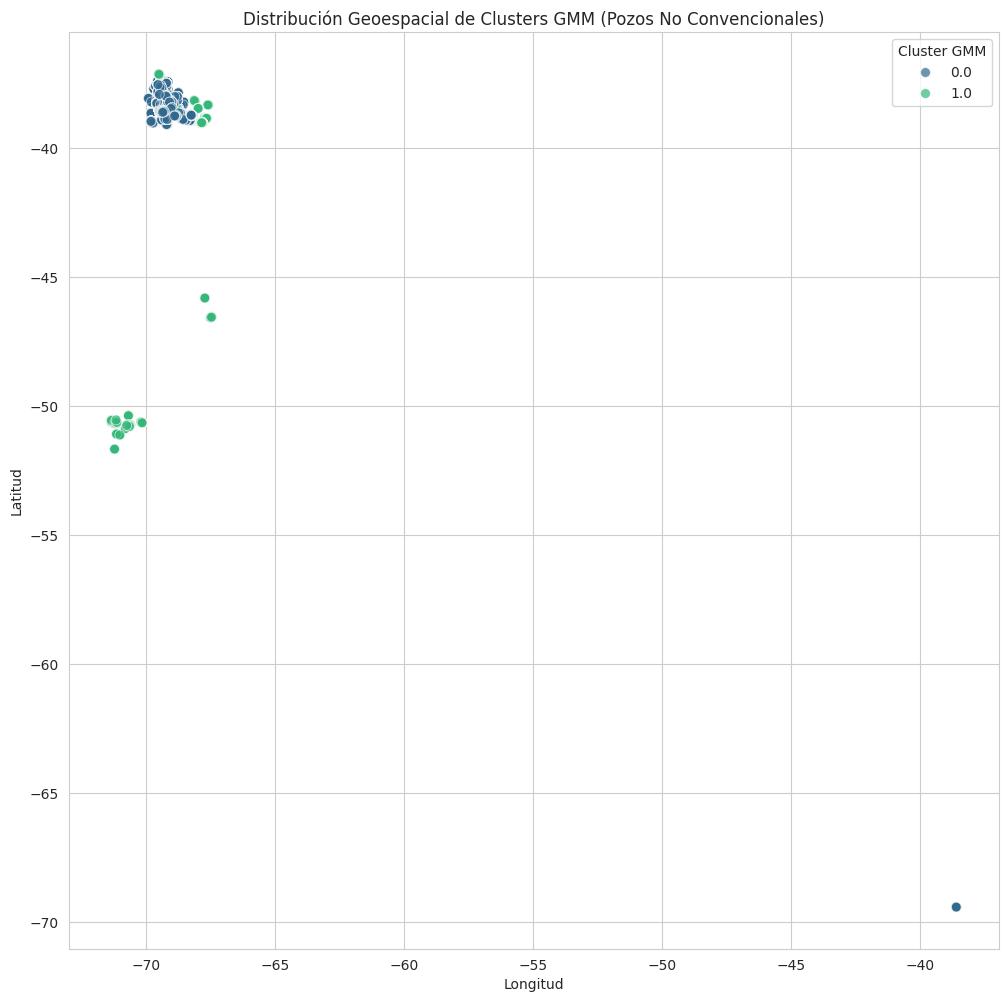


--- Características promedio por Cluster (GMM - Dataset2) - Valores Originales: ---
                prod_gas   prod_pet   prod_agua  coordenaday  coordenadax
gmm_cluster                                                              
0.0          1206.607350  49.603219  165.541966   -38.648408   -68.870747
1.0           563.818311  67.361743   57.280996   -42.350972   -68.905121

--- Proporciones de Variables Categóricas por Cluster (GMM - Dataset2): ---

--- Cluster 0.0 ---
  cuenca:
cuenca
NEUQUINA    1.0
Name: proportion, dtype: float64
  provincia:
provincia
Neuquén    1.0
Name: proportion, dtype: float64
  sub_tipo_recurso:
sub_tipo_recurso
TIGHT    0.77
SHALE    0.23
Name: proportion, dtype: float64
  subclasificacion:
subclasificacion
DESARROLLO               0.94
EXPLORACION              0.04
EXTENSION                0.01
EXPLORATORIO PROFUNDO    0.01
Name: proportion, dtype: float64

--- Cluster 1.0 ---
  cuenca:
cuenca
NEUQUINA           0.71
AUSTRAL            0.29
GOLFO SAN 

In [ ]:
# Análisis de Clusters GMM (Dataset2)

print("\n--- Visualizando y Analizando Clusters GMM ---")

# Visualización de Clusters (GMM) en PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters GMM de Pozos No Convencionales (Dataset2) - PC1 vs PC2')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster GMM')
plt.grid(True)
plt.show()

# Visualización Geoespacial de Clusters (GMM)
plt.figure(figsize=(12, 12))
sns.scatterplot(x='coordenadax', y='coordenaday', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Distribución Geoespacial de Clusters GMM (Pozos No Convencionales)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Cluster GMM')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

#  Análisis de Características promedio por Cluster (GMM)
print("\n--- Características promedio por Cluster (GMM - Dataset2) - Valores Originales: ---")

# Columnas numéricas originales relevantes para el análisis de clusters
numerical_cols_for_analysis = ['prod_gas', 'prod_pet', 'prod_agua', 'coordenaday', 'coordenadax']

# Revisar que las columnas existen en df2_with_clusters
existing_numerical_cols = [col for col in numerical_cols_for_analysis if col in df2_with_clusters.columns]

if not existing_numerical_cols:
    print("Advertencia: Ninguna de las columnas numéricas especificadas se encontró en el DataFrame para el análisis de promedios.")
else:
    cluster_summary_gmm = df2_with_clusters.groupby('gmm_cluster')[
        existing_numerical_cols
    ].mean()
    print(cluster_summary_gmm)

#  Análisis de proporciones de variables categóricas por cluster (GMM)
print("\n--- Proporciones de Variables Categóricas por Cluster (GMM - Dataset2): ---")
if 'categorical_features_2' not in locals() and 'categorical_features_2' not in globals():
    print("Advertencia: La lista 'categorical_features_2' no está definida. No se puede realizar el análisis de variables categóricas.")
else:
    # Revisar que las columnas categóricas existen en df2_with_clusters
    existing_categorical_cols = [col for col in categorical_features_2 if col in df2_with_clusters.columns]

    if not existing_categorical_cols:
        print("Advertencia: Ninguna de las columnas categóricas especificadas se encontró en el DataFrame para el análisis de proporciones.")
    else:
        for cluster_id in sorted(df2_with_clusters['gmm_cluster'].unique()):
            cluster_data = df2_with_clusters[df2_with_clusters['gmm_cluster'] == cluster_id]
            print(f"\n--- Cluster {cluster_id} ---")
            for cat_col in existing_categorical_cols:
                if not cluster_data[cat_col].empty:
                    print(f"  {cat_col}:\n{cluster_data[cat_col].value_counts(normalize=True).round(2)}")
                else:
                    print(f"  {cat_col}: No hay datos para este clúster.")

### **Análisis Detallado de Clusters GMM (Dataset2: Producción de Pozos No Convencionales)**

El modelo Gaussian Mixture Models (GMM) dividió el conjunto de pozos no convencionales en dos grandes grupos, permitiendo una segmentación más flexible que otros métodos al considerar formas de clúster más complejas.

**Cluster 0.0 – Alta Productividad en Neuquén**

Este grupo reúne pozos con muy alta producción de gas (promedio ~1200 m³), y niveles moderados de petróleo y agua.
Todos los pozos están ubicados en la Cuenca Neuquina, específicamente en la provincia de Neuquén, lo que indica una fuerte concentración geográfica.
* **Tipo de recurso:** Mayoría TIGHT (77%), seguido por SHALE (23%).
* **Fase del proyecto:** Predomina la fase de desarrollo (94%).

Representa el **corazón de la actividad no convencional** en Vaca Muerta, con pozos de alto rendimiento y desarrollo intensivo.

**Cluster 1.0 – Producción Mixta en Regiones Diversas**

Incluye pozos con una producción más equilibrada, donde el gas es moderado (560 m³ aprox.), pero el petróleo tiene mayor presencia (67 m³ aprox.).

Estos pozos están distribuidos en varias provincias, principalmente en Río Negro y Santa Cruz, con menor presencia en Neuquén y Mendoza.

* **Tipo de recurso:** Casi exclusivamente TIGHT (98%).
* **Fase:** Mayor diversidad, con presencia importante de pozos en fase avanzada (24%) y desarrollo (71%).

Representa **zonas más heterogéneas**, con una combinación de recursos y estrategias productivas, orientadas tanto a gas como a petróleo.

**Casos No Asignados (NaN)**

Algunos pozos no fueron asignados a ningún clúster, lo que puede deberse a que GMM no los incluye en sus componentes principales, aunque no los marca explícitamente como “ruido” como lo hace DBSCAN.

---

**Conclusión**

El modelo GMM proporciona una **visión general clara y estratégica** del panorama de producción no convencional en Argentina:

* Por un lado, Neuquén se destaca como el epicentro gasífero, con pozos altamente productivos.

* Por otro, aparece un segundo grupo más diverso en ubicación y características, reflejando enfoques técnicos variados y recursos mixtos.

GMM resulta útil para un análisis de alto nivel, y puede complementarse con métodos más detallados como DBSCAN, ideal para profundizar en particularidades o identificar anomalías.

#### 📊 Comparación  

- Comparación entre K-Means, DBSCAN y GMM

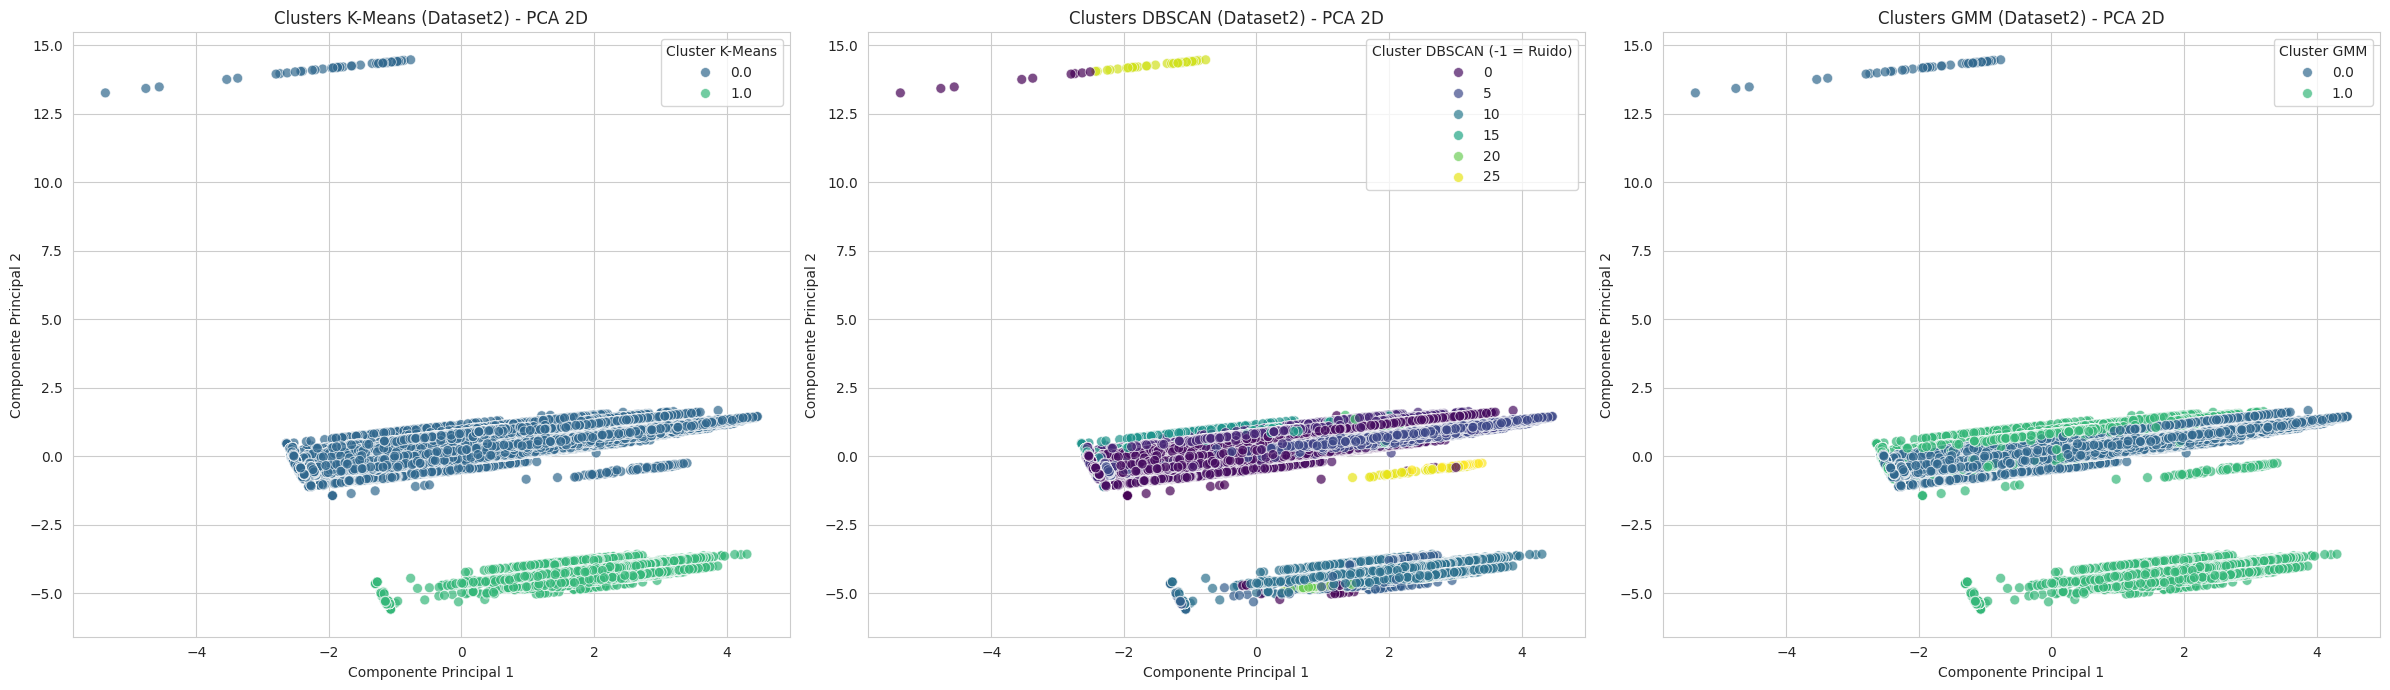

In [ ]:
# Visualización Comparativa de Clusters (K-Means, DBSCAN, GMM) en PCA 2D

plt.figure(figsize=(24, 7))

# Gráfico de Clusters (K-Means)
plt.subplot(1, 3, 1)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='kmeans_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters K-Means (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster K-Means')
plt.grid(True)

# Gráfico de Clusters (DBSCAN)
plt.subplot(1, 3, 2)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='dbscan_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN (-1 = Ruido)')
plt.grid(True)

# Gráfico de Clusters (GMM)
plt.subplot(1, 3, 3)
sns.scatterplot(x='pca1_viz_plot', y='pca2_viz_plot', hue='gmm_cluster', data=df2_with_clusters, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters GMM (Dataset2) - PCA 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster GMM')
plt.grid(True)

plt.tight_layout()
plt.show()

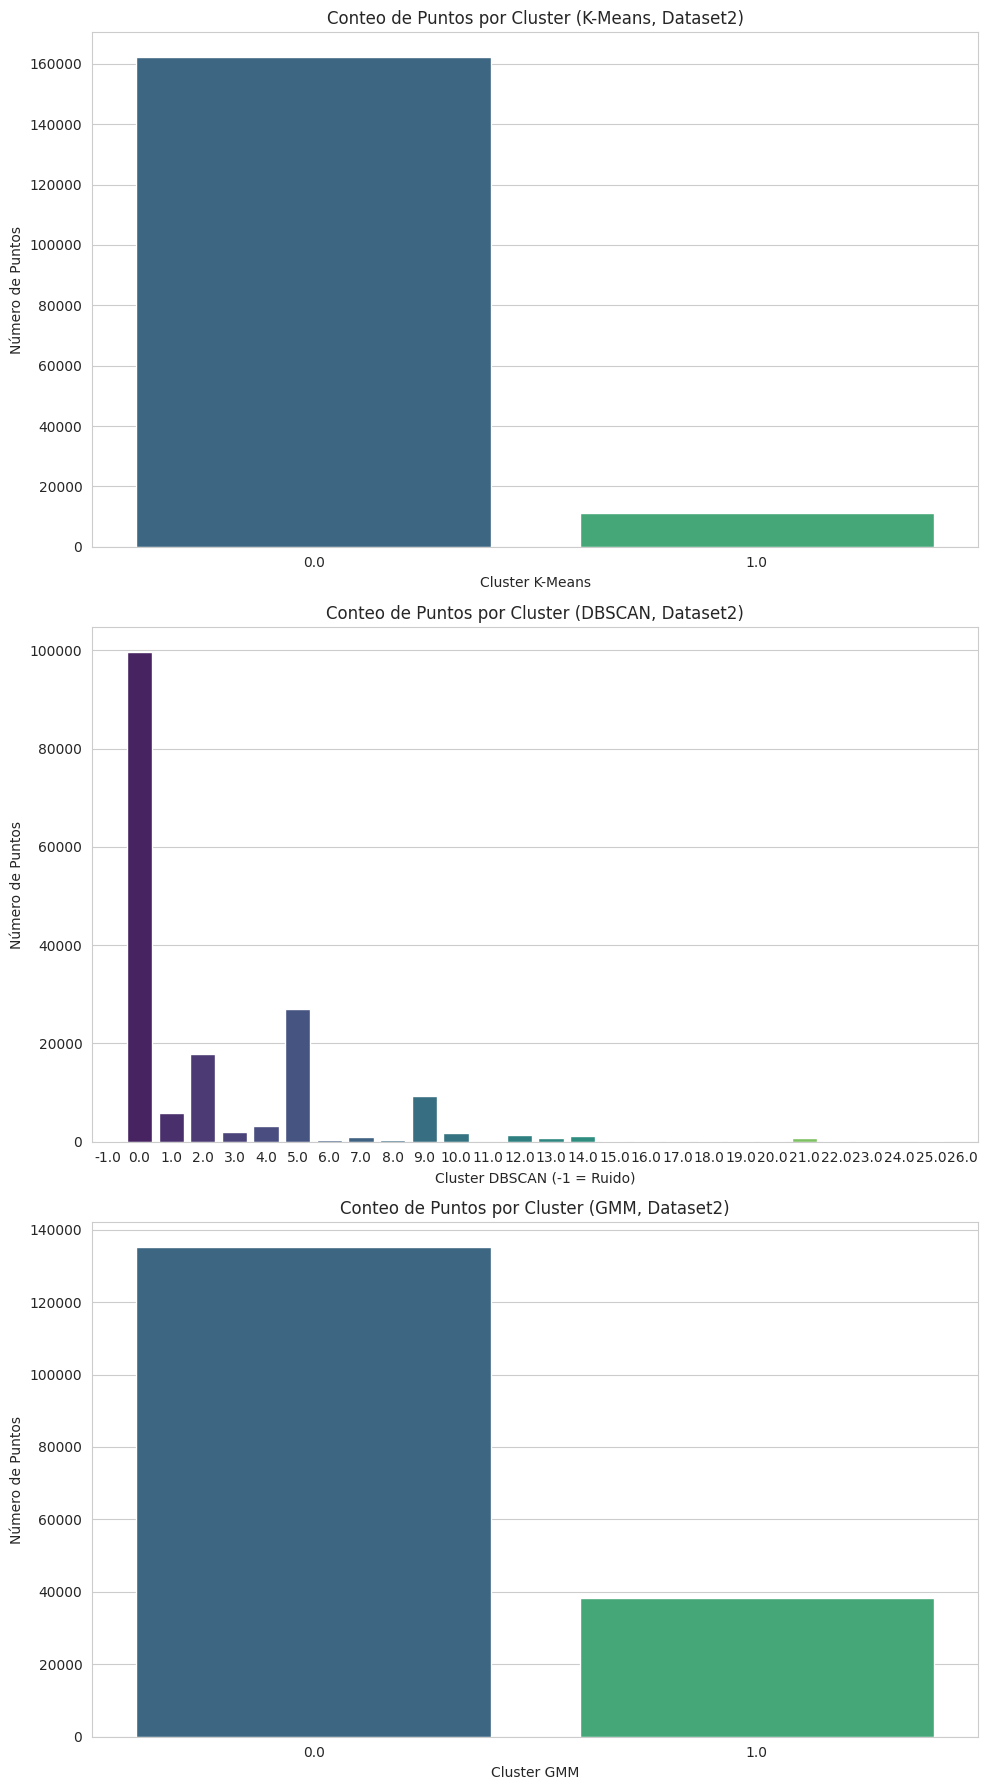

In [ ]:
# Conteo de Puntos por Clusters según Modelo

plt.figure(figsize=(10, 18))

# Conteo para K-Means
plt.subplot(3, 1, 1)
kmeans_counts = df2_with_clusters['kmeans_cluster'].value_counts().sort_index()
sns.barplot(x=kmeans_counts.index, y=kmeans_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (K-Means, Dataset2)')
plt.xlabel('Cluster K-Means')
plt.ylabel('Número de Puntos')
plt.xticks(rotation=0)

# Conteo para DBSCAN
plt.subplot(3, 1, 2)
dbscan_counts = df2_with_clusters['dbscan_cluster'].value_counts().sort_index()
sns.barplot(x=dbscan_counts.index, y=dbscan_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (DBSCAN, Dataset2)')
plt.xlabel('Cluster DBSCAN (-1 = Ruido)')
plt.ylabel('Número de Puntos')
plt.xticks(rotation=0)

# Conteo para GMM
plt.subplot(3, 1, 3)
gmm_counts = df2_with_clusters['gmm_cluster'].value_counts().sort_index()
sns.barplot(x=gmm_counts.index, y=gmm_counts.values, palette='viridis')
plt.title('Conteo de Puntos por Cluster (GMM, Dataset2)')
plt.xlabel('Cluster GMM')
plt.ylabel('Número de Puntos')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### **Comparación entre GMM, K-Means y DBSCAN**

Los tres algoritmos aplicados al Dataset2 ofrecen distintas formas de agrupar los pozos no convencionales:

**K-Means**

Agrupa en función de distancias, formando clústeres esféricos. Generó dos grupos principales según niveles de producción: uno de alta productividad concentrado en Neuquén, y otro con producción baja o intermedia en otras provincias. Es rápido y fácil de interpretar, pero limitado ante formas complejas o ruido.

**DBSCAN**

Basado en densidad, detecta automáticamente clústeres de cualquier forma y outliers. Identificó 27 clústeres y un grupo de ruido, permitiendo una segmentación muy detallada por cuenca, tipo de recurso y fase. Es ideal para exploración fina y detección de anomalías.

**GMM**
Asume que los datos siguen una mezcla de gaussianas, permitiendo clústeres elípticos y asignaciones probabilísticas. Formó dos grupos: uno altamente productivo en Neuquén (TIGHT/SHALE en desarrollo) y otro más diverso, con mayor producción de petróleo, en Río Negro y Santa Cruz.

### 🧾 Conclusiones Generales sobre los Patrones en Dataset2  

**1. Dominio de la Cuenca Neuquina**

Los tres modelos coinciden en identificar a **Neuquén** como núcleo de la **mayor productividad gasífera**.
Este patrón está claramente marcado por pozos en fase de desarrollo, principalmente de tipo TIGHT y SHALE. DBSCAN además distingue entre estas tecnologías y revela subzonas de interés en Mendoza y Río Negro.

**2. Producción Mixta y Diversidad Geográfica**

Otro patrón importante se da en **Río Negro, Santa Cruz y Mendoza**, donde los pozos presentan menor producción de gas pero **mayor presencia de petróleo**, en fases más avanzadas. K-Means y GMM captan este grupo más heterogéneo, mientras DBSCAN lo descompone en múltiples clústeres por cuenca.

**3. Pozos Atípicos o con Comportamiento Inusual**

DBSCAN detectó 183 pozos como outliers, con combinaciones atípicas como nula producción de hidrocarburos y alta producción de agua. Estos casos podrían reflejar pozos inactivos, de servicio, o errores de registro, y requieren análisis puntual.

**4. Impacto de la Frecuencia y Densidad de Pozos**

Cada modelo responde distinto según la forma y densidad de los datos:

| Modelo   | Enfoque Principal | Fortalezas | Limitaciones |
|----------|-------------------|------------|--------------|
| **K-Means** | Centrado en centroides (formas esféricas) | Visión rápida y global de los patrones predominantes | No maneja bien ruido ni formas complejas |
| **GMM**     | Asume distribución gaussiana (formas elípticas) | Flexibilidad en las formas, asignaciones probabilísticas | Menos granularidad |
| **DBSCAN**  | Densidad local de puntos | Detecta clústeres pequeños y outliers, granularidad alta | Sensible a los parámetros, más complejo de interpretar |

---

#### **Conclusión Final**

Los pozos no convencionales de Argentina pueden clasificarse en grupos bien definidos según su productividad y ubicación. Esto permite:

* Entender mejor los tipos de activos disponibles
* Analizar sus características técnicas
* Tomar decisiones estratégicas o de inversión más informadas

La elección del algoritmo depende del objetivo del análisis:
* K-Means y GMM son útiles para una visión general o estratégica
* DBSCAN es ideal para análisis detallados y detección de anomalías


---

### 🧾 **Conclusiones Generales de los insights de los Modelos No Supervisados**

El análisis con modelos no supervisados revela una transición estructural en la industria:

**Dataset 1:** Muestra el cambio desde la producción convencional a la no convencional (shale y tight gas), con Neuquén como protagonista. K-Means identifica la transición global, mientras DBSCAN revela fases intermedias y micro-patrones temporales.

**Dataset 2:** Confirma que la Cuenca Neuquina alberga los pozos más productivos, principalmente en desarrollo y con alto contenido de gas. Paralelamente, hay zonas con producción mixta y diversa en Río Negro, Santa Cruz y Mendoza. La detección de outliers por parte de DBSCAN subraya la importancia de investigar pozos con comportamiento anómalo, tanto para corregir errores como para detectar nuevas oportunidades.

